# <center> MODELO TERMODINÁMICO SISTEMA ACTUAL DE REFRIGERACIÓN

In [1]:
import pandas as pd
import CoolProp.CoolProp as CP
import numpy as np
from numpy import array
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import math
import time
from scipy.optimize import fsolve, curve_fit,least_squares
import warnings
import logging
from joblib import Parallel, delayed # Para paraleliza
from tqdm.notebook import tqdm # Usar tqdm.notebook si estás en Jupyter/Colab, sino solo tqdm
import sys
import traceback

## <center> Modelo termodinamico del sistema actual

![alt text](<diagrama de ciclo.drawio-1.svg>) 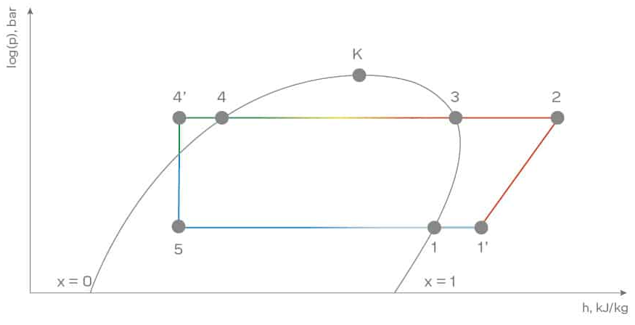

## <center> Datos de entrada

### Datos generales

In [2]:
refrigerante = 'R22'
masa_refrigerante = 2.7  # kg
T_leche_inicial = 30.3 + 273.15  # °C a K
T_leche_final = 3.5 + 273.15  # °C a K

fat_percent = 3.5

T_ambiente = 13.1 + 273.15  # K
costo_kwh = 855.04  # COP/kWh
tiempo_enfriamiento_horas = 3  # Horas

## <center> Parametros de la leche

In [3]:
calor_especifico_leche = 4134.42  # J/(kg*K) a la temperatura promedio del proceso, calculada con la ecuacion encontrada en el articulo Determination of specific heat of milk at different fat content between 1 °C and 59 °C using micro DSC, con un contenido de grasa del 3.5%
volumen_leche = 1950  # litros
densidad_leche = 1.0306  # kg/l. Valor promedio calculado, tomado de https://books.lib.uoguelph.ca/dairyscienceandtechnologyebook/chapter/physical-properties-of-milk/
masa_leche = volumen_leche * densidad_leche  # kg

## <center> Parametros del tanque

In [4]:

# --- Propiedades del tanque ---
e_acero_mm = 2.5      # mm
e_pur_mm = 75.0       # mm
k_acero = 16.0        # W/(m.K)
k_pur = 0.025         # W/(m.K)
h_int = 1000.0        # W/(m^2.K)
h_ext = 10.0          # W/(m^2.K)

V_tanque = volumen_leche / 1000.0 # m^3

# --- Espesores en metros ---
e_acero = e_acero_mm / 1000.0
e_pur = e_pur_mm / 1000.0

# --- Dimensiones Externas Conocidas  ---
D_externo_conocido_mm = 1600.0 # mm
H_externa_conocida_mm = 1330.0 # mm

# Convertir dimensiones conocidas a metros
D_externo_m = D_externo_conocido_mm / 1000.0 # m
H_externa_m = H_externa_conocida_mm / 1000.0 # m
r_externo_m = D_externo_m / 2.0           # m (Radio externo real)

# --- Cálculo de Radios (basado en la dimensión externa conocida) ---
# r3 es el radio más externo
r3 = r_externo_m
# r2 es el radio hasta la cara externa del acero
r2 = r3 - e_pur
# r1 es el radio interno del tanque
r1 = r2 - e_acero

# --- Cálculo del área externa ---
A_lat_ext = math.pi * (2 * r3) * H_externa_m  # Área lateral externa (usa H conocida)
A_bases_ext = 2 * math.pi * r3**2             # Área de las dos bases externas
A_externa = A_lat_ext + A_bases_ext         # m^2 (Área externa total)

# --- 
print(f"--- Resultados del Tanque (Dimensiones Conocidas) ---")
print(f"Radio interno (r1): {r1:.4f} m")
print(f"Radio hasta ext. acero (r2): {r2:.4f} m")
print(f"Radio externo (r3): {r3:.4f} m")
print(f"Altura externa (H): {H_externa_m:.4f} m")
print(f"Área externa total (A_externa): {A_externa:.4f} m^2")
print(f"Volumen interno del tanque (V_tanque): {V_tanque:.4f} m^3")

--- Resultados del Tanque (Dimensiones Conocidas) ---
Radio interno (r1): 0.7225 m
Radio hasta ext. acero (r2): 0.7250 m
Radio externo (r3): 0.8000 m
Altura externa (H): 1.3300 m
Área externa total (A_externa): 10.7065 m^2
Volumen interno del tanque (V_tanque): 1.9500 m^3


### Por balance de energía en el evaporador podemos obtener lo siguiente

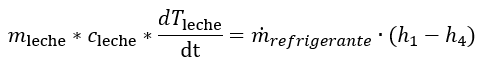

#### Se hace una verificacion de como varia Q a medida que la temperatura disminuye

In [5]:
temperaturas = np.linspace(30.3+273.15, 3.5+273.15, 50) #K

q = (masa_leche * (calor_especifico_leche * 1000.0) * (temperaturas - (3.5+273.15)))/1e6 #MJ

print(f'Las temperaturas muestreadas son {temperaturas} °C')

print(f'El calor requerido a medida que se llega a una temperatura es {q} J')

Las temperaturas muestreadas son [303.45       302.90306122 302.35612245 301.80918367 301.2622449
 300.71530612 300.16836735 299.62142857 299.0744898  298.52755102
 297.98061224 297.43367347 296.88673469 296.33979592 295.79285714
 295.24591837 294.69897959 294.15204082 293.60510204 293.05816327
 292.51122449 291.96428571 291.41734694 290.87040816 290.32346939
 289.77653061 289.22959184 288.68265306 288.13571429 287.58877551
 287.04183673 286.49489796 285.94795918 285.40102041 284.85408163
 284.30714286 283.76020408 283.21326531 282.66632653 282.11938776
 281.57244898 281.0255102  280.47857143 279.93163265 279.38469388
 278.8377551  278.29081633 277.74387755 277.19693878 276.65      ] °C
El calor requerido a medida que se llega a una temperatura es [222676.37174952 218131.95599953 213587.54024954 209043.12449955
 204498.70874956 199954.29299957 195409.87724958 190865.46149959
 186321.0457496  181776.62999961 177232.21424962 172687.79849963
 168143.38274964 163598.96699965 159054.5512496

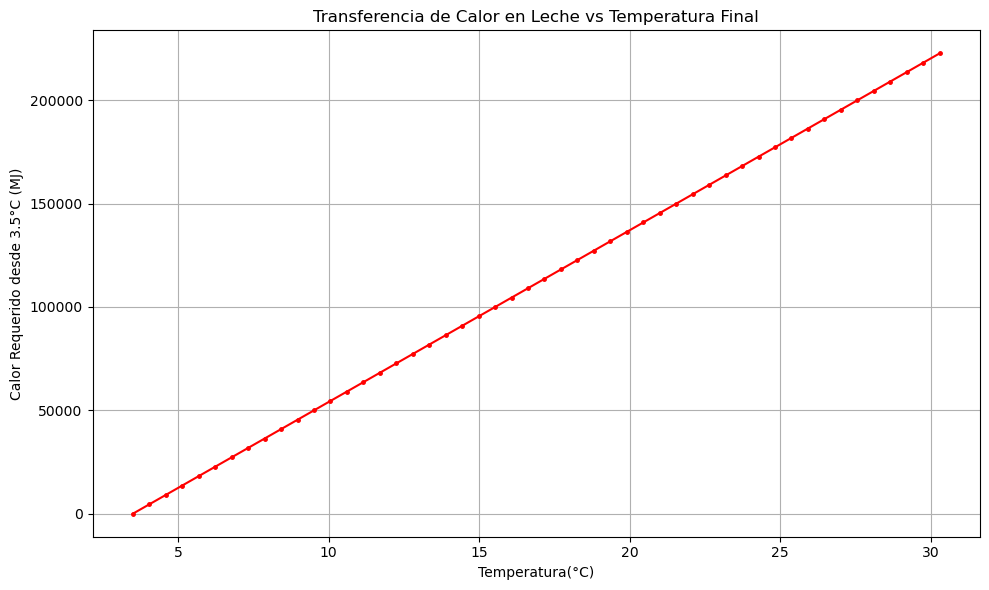

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(temperaturas-273.15, q, color='red', linestyle='-', marker='.', markersize=5, label='Calor Requerido')
plt.xlabel("Temperatura(°C)")
plt.ylabel("Calor Requerido desde 3.5°C (MJ)") # Etiqueta del eje Y con unidades
plt.title("Transferencia de Calor en Leche vs Temperatura Final") # Título descriptivo
plt.grid(True)
plt.tight_layout()
plt.show()

### <center> Verificando la curva de enfriamiento obtenida en campo, realizando un ajuste tanto exponencial como cuadratico por verificacion

In [7]:
nom = 'datos_enfriamiento.csv'

df = pd.read_csv(nom,sep=';')

In [8]:
df['TEMP (K)'] = df['TEMP (°C)']+273.15


=============== Análisis para: TEMP (K) ===============

--- Iniciando Ajuste EXPONENCIAL para: TEMP (K) ---
    (Aplicando ponderación Sigma: Base=1.00E-01, Último=1.00E-02)
Resultados del Ajuste Exponencial (Ponderado):
  Ecuación: T(t) = a * exp(-b * t) + c
  a = 3.377E+01 ± 5.912E-01
  b = 8.847E-05 ± 4.420E-06
  c = 269.341 ± 0.703
  R² = 0.99054
  -> CUMPLE R² >= 0.950


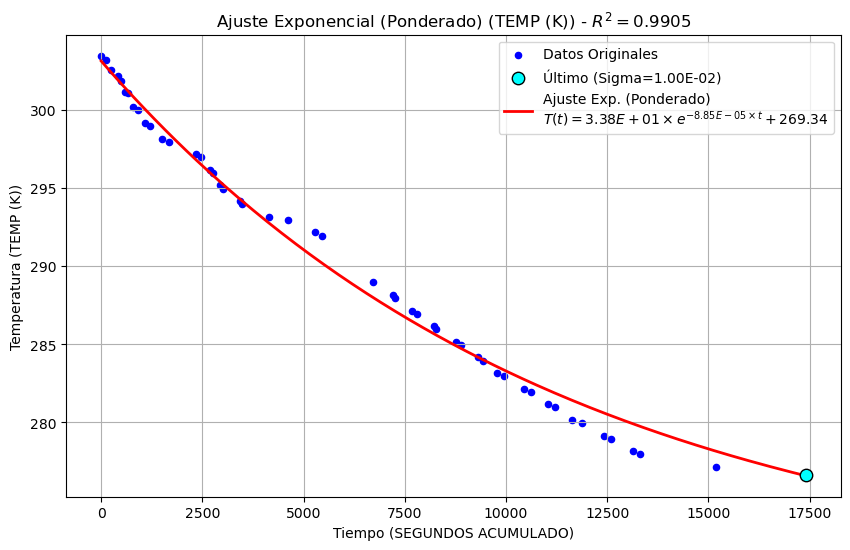

----------------------------------------

--- Iniciando Ajuste CUADRÁTICO para: TEMP (K) ---
    (Aplicando ponderación Pesos W: Base=1.00E+00, Último=1.00E+02)
Resultados del Ajuste Cuadrático (Ponderado):
  Ecuación: T(t) = a*t² + b*t + c
  a = 6.45510E-08
  b = -2.62753E-03
  c = 302.82525
  R² = 0.99337
  -> CUMPLE con el criterio R² >= 0.950


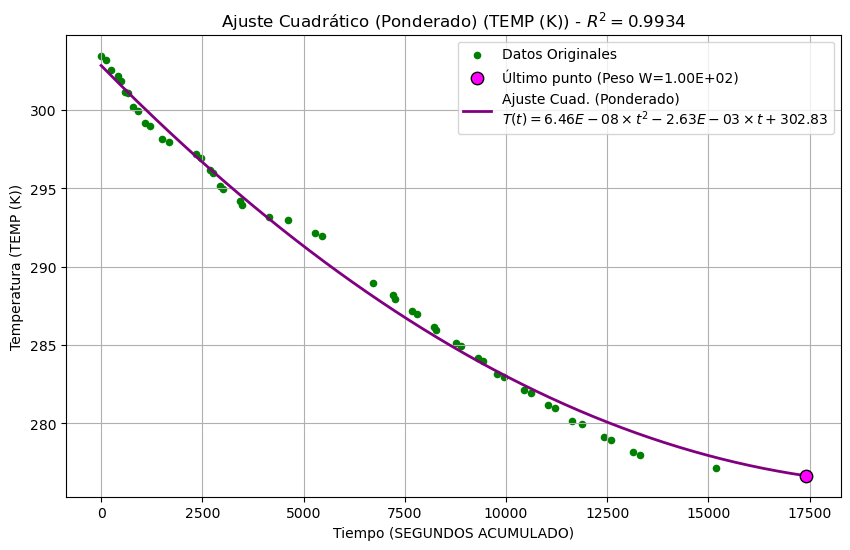


=============== Fin de todos los análisis ===============

Resumen de R² obtenidos:
  TEMP (K):
    - Exponencial(Ponderado): R² = 0.99054
    - Cuadrático(Ponderado): R² = 0.99337


In [9]:
# --- PASO 1: Preparación de Datos ---
if 'df' not in locals() or not isinstance(df, pd.DataFrame):
    raise NameError("El DataFrame 'df' no está definido o no es un DataFrame de Pandas. \n"
                    "Asegúrate de cargarlo antes de ejecutar este script o descomenta el ejemplo.")


# --- PASO 2: Definiciones de Modelos y Funciones de Ajuste ---

# --- Modelo Exponencial (Original) ---
def modelo_exponencial(t, a, b, c):
    """Modelo exponencial: T(t) = a * exp(-b * t) + c"""
    return a * np.exp(-b * t) + c

# --- Función de Ajuste Exponencial (Ponderada con sigma) ---
def realizar_ajuste_exponencial(df, col_tiempo, col_temp, r2_umbral=0.95,
                                sigma_predeterminado=1.0, sigma_ultimo_punto=None):
    """Realiza un ajuste exponencial ponderado usando sigma."""
    # ... (código de la función exponencial ponderada de la respuesta anterior)...
    # (No se pega aquí por brevedad, es la misma que la respuesta anterior)
    print(f"\n--- Iniciando Ajuste EXPONENCIAL para: {col_temp} ---")
    sigma_base = max(sigma_predeterminado, 1e-9) if sigma_predeterminado is not None else 1.0
    sigma_ultimo = max(sigma_ultimo_punto, 1e-9) if sigma_ultimo_punto is not None else sigma_base
    title_suffix = ""
    using_weights = not (np.isclose(sigma_base, 1.0) and np.isclose(sigma_ultimo, 1.0))
    if using_weights:
         title_suffix = "(Ponderado)"
         print(f"    (Aplicando ponderación Sigma: Base={sigma_base:.2E}, Último={sigma_ultimo:.2E})")
    try:
        x_data = df[col_tiempo].values
        y_data = df[col_temp].values
        n_points = len(x_data)
        if n_points < 3:
             print(f"Advertencia: Datos insuficientes ({n_points}). Saltando ajuste.")
             return None
    except KeyError as e: print(f"Error: Columna '{e}' no encontrada."); return None
    except Exception as e: print(f"Error al acceder datos: {e}"); return None

    sigma_array = np.full_like(y_data, fill_value=sigma_base, dtype=float)
    if n_points > 0: sigma_array[-1] = sigma_ultimo
    try:
        sort_indices = np.argsort(x_data)
        x_data_sorted = x_data[sort_indices]; y_data_sorted = y_data[sort_indices]
        temp_inicial_aprox = y_data_sorted[0]; c_inicial = min(y_data_sorted)
        a_inicial = temp_inicial_aprox - c_inicial if (temp_inicial_aprox - c_inicial) > 1e-6 else 1.0
        try:
             t_medio = x_data_sorted[np.where(y_data_sorted <= c_inicial + a_inicial / 2)[0][0]]
             b_inicial = np.log(2) / t_medio if t_medio > 1e-6 else 0.001
        except IndexError:
             t_total = x_data_sorted[-1] - x_data_sorted[0]
             b_inicial = 1 / t_total if t_total > 1e-6 else 0.001
        p0 = [a_inicial, b_inicial, c_inicial]
    except Exception as e_p0:
        print(f"Advertencia p0 ({e_p0}). Usando genéricos.")
        p0 = [np.ptp(y_data) if np.ptp(y_data) > 0 else 1.0, 0.001, np.min(y_data)]
    try:
        params_opt, cov_matrix = curve_fit(modelo_exponencial, x_data, y_data, p0=p0,
                                           sigma=sigma_array, absolute_sigma=False, maxfev=5000)
        a_opt, b_opt, c_opt = params_opt
        y_pred = modelo_exponencial(x_data, *params_opt)
        ss_res = np.sum((y_data - y_pred)**2); ss_tot = np.sum((y_data - np.mean(y_data))**2)
        if ss_tot < 1e-10: r_squared = 1.0 if ss_res < 1e-10 else 0.0
        else: r_squared = 1 - (ss_res / ss_tot)
        desviacion_std = np.array([np.nan] * len(params_opt))
        if cov_matrix is not None and np.all(np.isfinite(cov_matrix)):
             try:
                 varianzas = np.diag(cov_matrix)
                 if not np.any(varianzas < 0) and np.all(np.isfinite(varianzas)):
                      desviacion_std = np.sqrt(varianzas)
             except Exception: pass
        a_std, b_std, c_std = desviacion_std
        print(f"Resultados del Ajuste Exponencial {title_suffix}:")
        print(f"  Ecuación: T(t) = a * exp(-b * t) + c")
        a_std_str=f"± {a_std:.3E}" if not np.isnan(a_std) else "± N/A"; b_std_str=f"± {b_std:.3E}" if not np.isnan(b_std) else "± N/A"; c_std_str=f"± {c_std:.3f}" if not np.isnan(c_std) else "± N/A"
        print(f"  a = {a_opt:.3E} {a_std_str}"); print(f"  b = {b_opt:.3E} {b_std_str}"); print(f"  c = {c_opt:.3f} {c_std_str}")
        print(f"  R² = {r_squared:.5f}"); print(f"  -> {'CUMPLE' if r_squared >= r2_umbral else 'NO CUMPLE'} R² >= {r2_umbral:.3f}")
        plt.figure(figsize=(10, 6)); plt.scatter(x_data, y_data, label='Datos Originales', color='blue', s=20)
        if n_points > 0 and not np.isclose(sigma_ultimo, sigma_base):
             plt.scatter(x_data[-1], y_data[-1], color='cyan', edgecolor='black', s=80, label=f'Último (Sigma={sigma_ultimo:.2E})', zorder=5)
        x_fit = np.linspace(min(x_data), max(x_data), 200); y_fit = modelo_exponencial(x_fit, *params_opt)
        label_fit = (f'Ajuste Exp. {title_suffix}\n$T(t) = {a_opt:.2E} \\times e^{{{-b_opt:.2E} \\times t}} {c_opt:+.2f}$')
        plt.plot(x_fit, y_fit, label=label_fit, color='red', linewidth=2)
        plt.title(f'Ajuste Exponencial {title_suffix} ({col_temp}) - $R^2 = {r_squared:.4f}$'); plt.xlabel(f'Tiempo ({col_tiempo})'); plt.ylabel(f'Temperatura ({col_temp})')
        plt.legend(); plt.grid(True); plt.show()
        return {'params': params_opt, 'cov': cov_matrix, 'R2': r_squared}
    except RuntimeError: print("Error: Ajuste exponencial no convergió."); return None
    except Exception as e: print(f"Error inesperado ajuste exp: {e}"); import traceback; traceback.print_exc(); return None


# --- Función de Ajuste Cuadrático (Modificada para incluir pesos w) ---
def realizar_ajuste_cuadratico(df, col_tiempo, col_temp, r2_umbral=0.95,
                               peso_predeterminado=1.0, peso_ultimo_punto=None):
    """
    Realiza un ajuste cuadrático ponderado usando pesos 'w'.

    Permite asignar un peso base a todos los puntos y un peso específico (opcionalmente
    diferente y mayor) al último punto para darle importancia adicional.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        col_tiempo (str): Nombre de la columna de tiempo.
        col_temp (str): Nombre de la columna de temperatura.
        r2_umbral (float): Umbral de R^2 para considerar el ajuste bueno.
        peso_predeterminado (float): Peso ('w') para todos los puntos (excepto quizás el último).
                                     Un valor > 1.0 da más peso que el estándar. Debe ser > 0.
        peso_ultimo_punto (float, optional): Peso ('w') específico para el último punto.
                                             Si es None, usa peso_predeterminado.
                                             Si se especifica, debe ser > 0.
                                             Si > peso_predeterminado, da MÁS peso al último punto.
    """
    print(f"\n--- Iniciando Ajuste CUADRÁTICO para: {col_temp} ---")

    # Validar y limpiar valores de peso
    peso_base = max(peso_predeterminado, 1e-9) if peso_predeterminado is not None else 1.0
    peso_ultimo = max(peso_ultimo_punto, 1e-9) if peso_ultimo_punto is not None else peso_base

    title_suffix = ""
    using_weights = not (np.isclose(peso_base, 1.0) and np.isclose(peso_ultimo, 1.0))
    if using_weights:
         title_suffix = "(Ponderado)"
         print(f"    (Aplicando ponderación Pesos W: Base={peso_base:.2E}, Último={peso_ultimo:.2E})")

    try:
        x_data = df[col_tiempo].values
        y_data = df[col_temp].values
        n_points = len(x_data)
        if n_points < 3:
             print(f"Advertencia: Datos insuficientes ({n_points}). Saltando ajuste cuadrático.")
             return None
    except KeyError as e:
        print(f"Error: Columna '{e}' no encontrada. Saltando ajuste cuadrático.")
        return None
    except Exception as e:
        print(f"Error al acceder a los datos: {e}")
        return None

    # --- Definición de Pesos W ---
    weights_array = np.full_like(y_data, fill_value=peso_base, dtype=float)
    if n_points > 0:
        weights_array[-1] = peso_ultimo # Aplicar peso específico al último punto

    try:
        # --- Ajuste Polinomial Ponderado ---
        coeffs = np.polyfit(x_data, y_data, 2, w=weights_array) # <--- Pasar los pesos aquí
        a_q, b_q, c_q = coeffs
        polinomio = np.poly1d(coeffs)

        # Calcular R^2 (sobre datos originales sin ponderar)
        y_pred = polinomio(x_data)
        ss_res = np.sum((y_data - y_pred)**2)
        ss_tot = np.sum((y_data - np.mean(y_data))**2)
        if ss_tot < 1e-10: r_squared = 1.0 if ss_res < 1e-10 else 0.0
        else: r_squared = 1 - (ss_res / ss_tot)

        # Mostrar Resultados
        print(f"Resultados del Ajuste Cuadrático {title_suffix}:")
        print(f"  Ecuación: T(t) = a*t² + b*t + c")
        print(f"  a = {a_q:.5E}")
        print(f"  b = {b_q:.5E}")
        print(f"  c = {c_q:.5f}")
        print(f"  R² = {r_squared:.5f}")
        print(f"  -> {'CUMPLE' if r_squared >= r2_umbral else 'NO CUMPLE'} con el criterio R² >= {r2_umbral:.3f}")

        # Visualización
        plt.figure(figsize=(10, 6))
        plt.scatter(x_data, y_data, label='Datos Originales', color='green', s=20)
         # Marcar el último punto si su peso es diferente al base
        if n_points > 0 and not np.isclose(peso_ultimo, peso_base):
             plt.scatter(x_data[-1], y_data[-1], color='magenta', edgecolor='black', s=80,
                         label=f'Último punto (Peso W={peso_ultimo:.2E})', zorder=5)

        x_fit = np.linspace(min(x_data), max(x_data), 200)
        y_fit = polinomio(x_fit)
        label_fit = (f'Ajuste Cuad. {title_suffix}\n'
                     f'$T(t) = {a_q:.2E} \\times t^2 {b_q:+.2E} \\times t {c_q:+.2f}$')
        plt.plot(x_fit, y_fit, label=label_fit, color='purple', linewidth=2)
        plt.title(f'Ajuste Cuadrático {title_suffix} ({col_temp}) - $R^2 = {r_squared:.4f}$')
        plt.xlabel(f'Tiempo ({col_tiempo})')
        plt.ylabel(f'Temperatura ({col_temp})')
        plt.legend()
        plt.grid(True)
        plt.show()
        return {'coeffs': coeffs, 'R2': r_squared}

    except np.linalg.LinAlgError as e_lin:
         print(f"Error: Problema numérico en ajuste polinomial (LinAlgError): {e_lin}")
         return None
    except Exception as e:
        print(f"Error inesperado durante el ajuste cuadrático: {e}")
        import traceback
        traceback.print_exc()
        return None


# --- PASO 3: Ejecutar los ajustes ---
columna_tiempo = 'SEGUNDOS ACUMULADO'
columnas_temperatura_a_ajustar = ['TEMP (K)']
umbral_r2_deseado = 0.95 # Ajusta según necesidad

# === Configuración de Ponderación ===

# --- EXPONENCIAL (Sigma: menor = más peso) ---
sigma_predeterminado_exp = 0.1   # Sigma base (<1.0 para dar peso a todos)
sigma_ultimo_exp = 0.01           # Sigma último (< sigma_predeterminado para MÁS peso al último)

# --- CUADRÁTICO (Peso W: mayor = más peso) ---
peso_predeterminado_quad = 1.0  # Peso W base (>1.0 para dar peso a todos)
peso_ultimo_quad = 100.0         # Peso W último (> peso_predeterminado para MÁS peso al último)

# =====================================

resultados_globales = {}

for temp_col in columnas_temperatura_a_ajustar:
    if temp_col not in df.columns:
        print(f"\nAdvertencia: Columna '{temp_col}' no encontrada. Saltando.")
        continue
    if columna_tiempo not in df.columns:
        print(f"\nError Fatal: Columna '{columna_tiempo}' no encontrada.")
        break

    print(f"\n{'='*15} Análisis para: {temp_col} {'='*15}")
    resultados_globales[temp_col] = {}

    # --- Ajuste Exponencial Ponderado ---
    res_exp = realizar_ajuste_exponencial(
        df, columna_tiempo, temp_col, umbral_r2_deseado,
        sigma_predeterminado=sigma_predeterminado_exp,
        sigma_ultimo_punto=sigma_ultimo_exp
    )
    if res_exp: resultados_globales[temp_col]['Exponencial'] = res_exp
    else: print(f"Ajuste exponencial para '{temp_col}' falló.")

    print("-" * 40)

    # --- Ajuste Cuadrático Ponderado ---
    res_quad = realizar_ajuste_cuadratico(
        df, columna_tiempo, temp_col, umbral_r2_deseado,
        peso_predeterminado=peso_predeterminado_quad, # <--- Pasar peso base
        peso_ultimo_punto=peso_ultimo_quad        # <--- Pasar peso último
    )
    if res_quad: resultados_globales[temp_col]['Cuadratico'] = res_quad
    else: print(f"Ajuste cuadrático para '{temp_col}' falló.")

print(f"\n{'='*15} Fin de todos los análisis {'='*15}")

# Opcional: Mostrar resumen de R^2 guardados
print("\nResumen de R² obtenidos:")
if not resultados_globales:
     print("  No se completaron análisis.")
else:
    for temp_col, ajustes in resultados_globales.items():
        print(f"  {temp_col}:")
        r2_exp = ajustes.get('Exponencial', {}).get('R2', None)
        r2_quad = ajustes.get('Cuadratico', {}).get('R2', None)

        # Determinar si se usó ponderación para los sufijos
        exp_weighted = not (np.isclose(sigma_predeterminado_exp, 1.0) and (sigma_ultimo_exp is None or np.isclose(sigma_ultimo_exp, sigma_predeterminado_exp)))
        quad_weighted = not (np.isclose(peso_predeterminado_quad, 1.0) and (peso_ultimo_quad is None or np.isclose(peso_ultimo_quad, peso_predeterminado_quad)))

        if r2_exp is not None:
            suffix_exp = "(Ponderado)" if exp_weighted else ""
            print(f"    - Exponencial{suffix_exp}: R² = {r2_exp:.5f}")
        else:
            print(f"    - Exponencial: Falló o no se realizó")

        if r2_quad is not None:
            suffix_quad = "(Ponderado)" if quad_weighted else ""
            print(f"    - Cuadrático{suffix_quad}: R² = {r2_quad:.5f}")
        else:
            print(f"    - Cuadrático:  Falló o no se realizó")

In [10]:
resultados_globales

{'TEMP (K)': {'Exponencial': {'params': array([3.37735867e+01, 8.84713334e-05, 2.69341148e+02]),
   'cov': array([[ 3.49467169e-01, -2.27933425e-06, -3.86161566e-01],
          [-2.27933425e-06,  1.95377813e-11,  3.05806855e-06],
          [-3.86161566e-01,  3.05806855e-06,  4.93709097e-01]]),
   'R2': 0.9905441892662238},
  'Cuadratico': {'coeffs': array([ 6.45509814e-08, -2.62752934e-03,  3.02825252e+02]),
   'R2': 0.9933720686265742}}}

#### Verificando la curva de enfriamiento obtenida en campo

In [11]:
tiempo_en_seg = np.linspace(0,tiempo_enfriamiento_horas*3600,100)

In [12]:
def ajuste_cuadratico(tiempo_en_seg, temp_unit='K'):
    """
    Calcula el ajuste cuadrático usando los coeficientes de resultados_globales.
    CORREGIDO para usar 'TEMP [K]' o 'TEMP (°C)'.

    Args:
        tiempo_en_seg (float or np.ndarray): El tiempo o array de tiempos.
        temp_unit (str): La unidad de temperatura ('K' o '°C') para seleccionar los coeficientes.

    Returns:
        float or np.ndarray: El valor o array de valores del ajuste cuadrático,
                             o None si hay un error.
    """
    # --- INICIO CORRECCIÓN ---
    if temp_unit == 'K':
        unit_key = 'TEMP (K)' # Usa corchetes para Kelvin
    elif temp_unit == '°C':
        unit_key = 'TEMP (°C)' # Usa paréntesis para Celsius
    else:
        print(f"Error: Unidad de temperatura '{temp_unit}' no reconocida.")
        return None
    # --- FIN CORRECCIÓN ---

    try:
        # Acceder a los coeficientes desde el diccionario global
        coeffs = resultados_globales[unit_key]['Cuadratico']['coeffs']
        a, b, c = coeffs[0], coeffs[1], coeffs[2]

        # Calcular el resultado usando la fórmula cuadrática
        resultado = a * (tiempo_en_seg**2) + b * tiempo_en_seg + c
        return resultado

    except KeyError as e:
        print(f"Error: No se encontró la clave {e} en resultados_globales para la clave final '{unit_key}'.")
        return None
    except IndexError:
        print(f"Error: El array de coeficientes cuadráticos no tiene 3 elementos para '{unit_key}'.")
        return None
    except NameError:
        print("Error: El diccionario 'resultados_globales' no está definido.")
        return None
    except Exception as e:
        print(f"Error inesperado en ajuste_cuadratico: {e}")
        return None


def ajuste_exponencial(tiempo_en_seg, temp_unit='K'):
    """
    Calcula el ajuste exponencial usando los parámetros de resultados_globales.
    Asume la forma: a * exp(b * t) + c
    CORREGIDO para usar 'TEMP [K]' o 'TEMP (°C)'.

    Args:
        tiempo_en_seg (float or np.ndarray): El tiempo o array de tiempos.
        temp_unit (str): La unidad de temperatura ('K' o '°C') para seleccionar los parámetros.

    Returns:
        float or np.ndarray: El valor o array de valores del ajuste exponencial,
                             o None si hay un error.
    """
    # --- INICIO CORRECCIÓN ---
    if temp_unit == 'K':
        unit_key = 'TEMP (K)' # Usa corchetes para Kelvin
    elif temp_unit == '°C':
        unit_key = 'TEMP (°C)' # Usa paréntesis para Celsius
    else:
        print(f"Error: Unidad de temperatura '{temp_unit}' no reconocida.")
        return None
    # --- FIN CORRECCIÓN ---

    try:
        # Acceder a los parámetros desde el diccionario global
        params = resultados_globales[unit_key]['Exponencial']['params']
        a, b, c = params[0], params[1], params[2]

        # Calcular el resultado usando la fórmula exponencial
        # Nota: Asegúrate que la forma a*exp(b*t)+c es la correcta para tu caso
        resultado = a * np.exp(-b * tiempo_en_seg) + c
        return resultado

    except KeyError as e:
        print(f"Error: No se encontró la clave {e} en resultados_globales para la clave final '{unit_key}'.")
        return None
    except IndexError:
         print(f"Error: El array de parámetros exponenciales no tiene 3 elementos para '{unit_key}'.")
         return None
    except NameError:
        print("Error: El diccionario 'resultados_globales' no está definido.")
        return None
    except Exception as e:
        print(f"Error inesperado en ajuste_exponencial: {e}")
        return None

# --- Ejemplo de Uso ---

# 1. El diccionario 'resultados_globales' ya está definido arriba.

# 2. Define tu variable de tiempo
tiempo_en_seg = np.linspace(0, 17400, 100)

# 3. Llama a las funciones corregidas (usando 'K' por defecto o especificando)


In [13]:
print("Calculando con unidad 'K':")
resultado_cuad_func_K = ajuste_cuadratico(tiempo_en_seg, temp_unit='K')
resultado_exp_func_K = ajuste_exponencial(tiempo_en_seg, temp_unit='K')

if resultado_cuad_func_K is not None:
    print("-> Ajuste cuadrático (K) calculado.")
if resultado_exp_func_K is not None:
    print("-> Ajuste exponencial (K) calculado.")

Calculando con unidad 'K':
-> Ajuste cuadrático (K) calculado.
-> Ajuste exponencial (K) calculado.


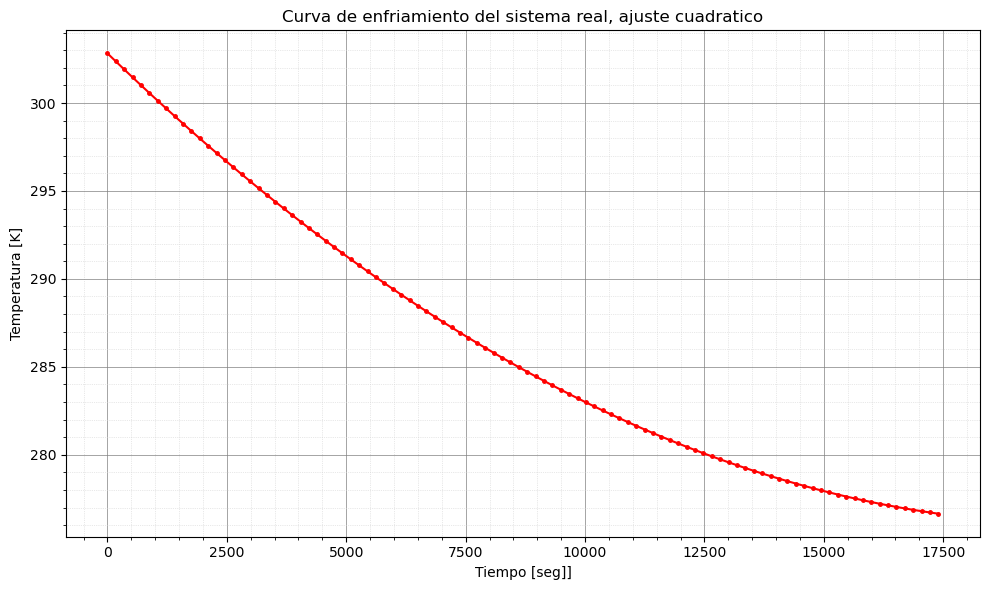

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(tiempo_en_seg, resultado_cuad_func_K, color='red', linestyle='-', marker='.', markersize=5)
plt.xlabel("Tiempo [seg]]")
plt.ylabel("Temperatura [K]") 
plt.title("Curva de enfriamiento del sistema real, ajuste cuadratico")
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray') 
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout()
plt.show()

In [15]:
resultado_exp_func_K

array([303.11473513, 302.59363444, 302.08057393, 301.57542955,
       301.07807917, 300.58840252, 300.10628121, 299.63159867,
       299.16424011, 298.70409254, 298.2510447 , 297.80498704,
       297.36581171, 296.93341252, 296.50768492, 296.08852597,
       295.67583432, 295.2695102 , 294.86945534, 294.47557303,
       294.08776802, 293.70594654, 293.33001628, 292.95988634,
       292.59546722, 292.23667081, 291.88341035, 291.53560043,
       291.19315696, 290.85599713, 290.52403941, 290.19720355,
       289.87541052, 289.55858251, 289.24664292, 288.93951631,
       288.63712844, 288.33940618, 288.04627754, 287.75767166,
       287.47351875, 287.19375009, 286.91829806, 286.64709604,
       286.38007846, 286.11718076, 285.85833937, 285.60349171,
       285.35257615, 285.10553203, 284.86229961, 284.62282008,
       284.38703553, 284.15488897, 283.92632424, 283.7012861 ,
       283.47972012, 283.26157274, 283.0467912 , 282.83532359,
       282.62711875, 282.42212636, 282.22029684, 282.02

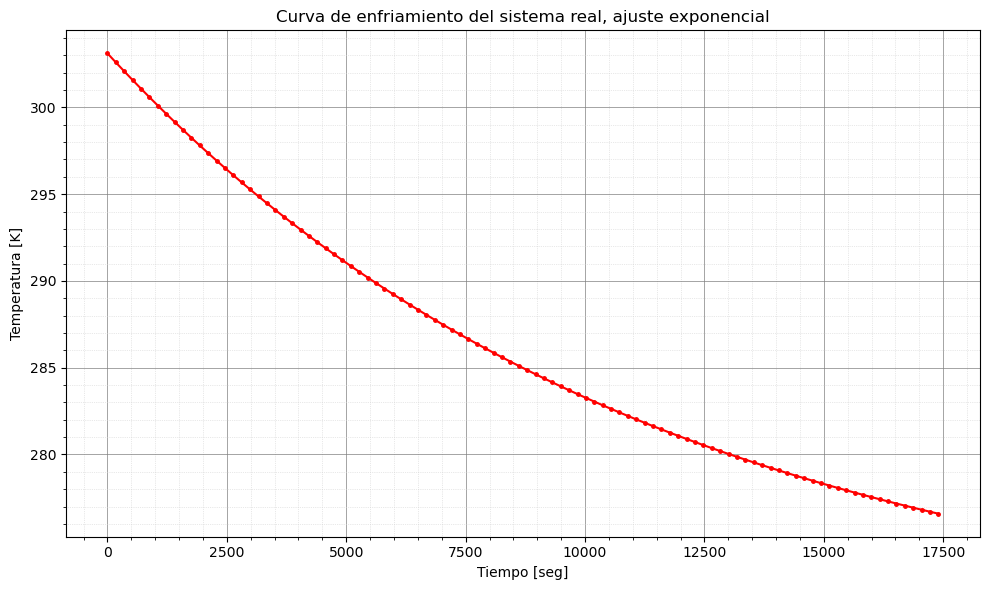

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(tiempo_en_seg, resultado_exp_func_K, color='red', linestyle='-', marker='.', markersize=5)
plt.xlabel("Tiempo [seg]")
plt.ylabel("Temperatura [K]") # Etiqueta del eje Y con unidades
plt.title("Curva de enfriamiento del sistema real, ajuste exponencial") # Título descriptivo
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray') 
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout()
plt.show()

##### Para poder hacer la estimacion de calor absorbido por el evaporador, tenemos que hacer la derivacion

In [17]:
t = sp.symbols('t')

In [18]:
def obtener_ecuacion_cuadratica_simbolica(temp_unit='K'):
    """
    Genera la ecuación cuadrática simbólica usando los coeficientes de resultados_globales.

    Args:
        temp_unit (str): La unidad de temperatura ('K' o '°C') para seleccionar los coeficientes.

    Returns:
        sp.Expr: La ecuación simbólica, o None si hay un error.
    """
    if temp_unit == 'K':
        unit_key = 'TEMP (K)'
    elif temp_unit == '°C':
        unit_key = 'TEMP (°C)'
    else:
        print(f"Error S: Unidad de temperatura '{temp_unit}' no reconocida.")
        return None

    try:
        # Extraer coeficientes
        coeffs = resultados_globales[unit_key]['Cuadratico']['coeffs']
        a_num, b_num, c_num = coeffs[0], coeffs[1], coeffs[2]

        # Definir el símbolo para el tiempo
        t = sp.symbols('t')

        # Crear la ecuación simbólica
        # Usamos sp.Float para mantener la precisión si es necesario, aunque no es estrictamente obligatorio
        ecuacion = sp.Float(a_num) * t**2 + sp.Float(b_num) * t + sp.Float(c_num)
        return ecuacion

    except KeyError as e:
        print(f"Error S: No se encontró la clave {e} en resultados_globales para la clave final '{unit_key}'.")
        return None
    except (IndexError, NameError, Exception) as e:
        print(f"Error S inesperado en obtener_ecuacion_cuadratica_simbolica: {e}")
        return None


def obtener_ecuacion_exponencial_simbolica(temp_unit='K'):
    """
    Genera la ecuación exponencial simbólica usando los parámetros de resultados_globales.
    Asume la forma: a * exp(-b * t) + c

    Args:
        temp_unit (str): La unidad de temperatura ('K' o '°C') para seleccionar los parámetros.

    Returns:
        sp.Expr: La ecuación simbólica, o None si hay un error.
    """
    if temp_unit == 'K':
        unit_key = 'TEMP (K)'
    elif temp_unit == '°C':
        unit_key = 'TEMP (°C)'
    else:
        print(f"Error S: Unidad de temperatura '{temp_unit}' no reconocida.")
        return None

    try:
        # Extraer parámetros
        params = resultados_globales[unit_key]['Exponencial']['params']
        a_num, b_num, c_num = params[0], params[1], params[2]

        # Definir el símbolo para el tiempo
        t = sp.symbols('t')

        # Crear la ecuación simbólica usando sp.exp
        # Usamos sp.Float para mantener la precisión
        ecuacion = sp.Float(a_num) * sp.exp(sp.Float(-b_num) * t) + sp.Float(c_num)
        return ecuacion

    except KeyError as e:
        print(f"Error S: No se encontró la clave {e} en resultados_globales para la clave final '{unit_key}'.")
        return None
    except (IndexError, NameError, Exception) as e:
        print(f"Error S inesperado en obtener_ecuacion_exponencial_simbolica: {e}")
        return None


In [19]:
eq_cuad_sym_K = obtener_ecuacion_cuadratica_simbolica(temp_unit='K')
eq_exp_sym_K = obtener_ecuacion_exponencial_simbolica(temp_unit='K')

In [20]:
print("Ecuación Cuadrática Simbólica (K):")
sp.pprint(eq_cuad_sym_K) # pprint para formato más legible
a, b, c = resultados_globales['TEMP (K)']['Cuadratico']['coeffs']
print(f"  (Parámetros: a={a:.4e}, b={b:.4e}, c={c:.4e})")

print("\nEcuación Exponencial Simbólica (K):")
sp.pprint(eq_exp_sym_K)
a, b, c = resultados_globales['TEMP (K)']['Exponencial']['params']
print(f"  (Parámetros: a={a:.4e}, b={b:.4e}, c={c:.4e})")

Ecuación Cuadrática Simbólica (K):
                     2                                          
6.45509813920865e-8⋅t  - 0.0026275293402363⋅t + 302.825251834786
  (Parámetros: a=6.4551e-08, b=-2.6275e-03, c=3.0283e+02)

Ecuación Exponencial Simbólica (K):
                                     -8.84713334194937e-5⋅t
269.341148472185 + 33.7735866622903⋅ℯ                      
  (Parámetros: a=3.3774e+01, b=8.8471e-05, c=2.6934e+02)


##### ahora derivando 

In [21]:
derivada_cuadratica = sp.diff(eq_cuad_sym_K, t)

# Derivada de la expresión exponencial
derivada_exponencial = sp.diff(eq_exp_sym_K, t)

print("Expresión Cuadrática Original:")
sp.pprint(eq_cuad_sym_K)
print("\nDerivada de la Expresión Cuadrática:")
sp.pprint(derivada_cuadratica)
print("\nExpresión Exponencial Original:")
sp.pprint(eq_exp_sym_K)
print("\nDerivada de la Expresión Exponencial:")
sp.pprint(derivada_exponencial)

Expresión Cuadrática Original:
                     2                                          
6.45509813920865e-8⋅t  - 0.0026275293402363⋅t + 302.825251834786

Derivada de la Expresión Cuadrática:
1.29101962784173e-7⋅t - 0.0026275293402363

Expresión Exponencial Original:
                                     -8.84713334194937e-5⋅t
269.341148472185 + 33.7735866622903⋅ℯ                      

Derivada de la Expresión Exponencial:
                      -8.84713334194937e-5⋅t
-0.00298799424637165⋅ℯ                      


#### Por lo que la tasa de enfriamiento de la leche es 

In [22]:
func_derivada_cuadratica_np = sp.lambdify(t, derivada_cuadratica, modules=['numpy'])

func_derivada_exponencial_np = sp.lambdify(t, derivada_exponencial, modules=['numpy'])


In [23]:
tasa_enfriamiento_cuadratica = func_derivada_cuadratica_np(tiempo_en_seg)
tasa_enfriamiento_exponencial = func_derivada_exponencial_np(tiempo_en_seg)

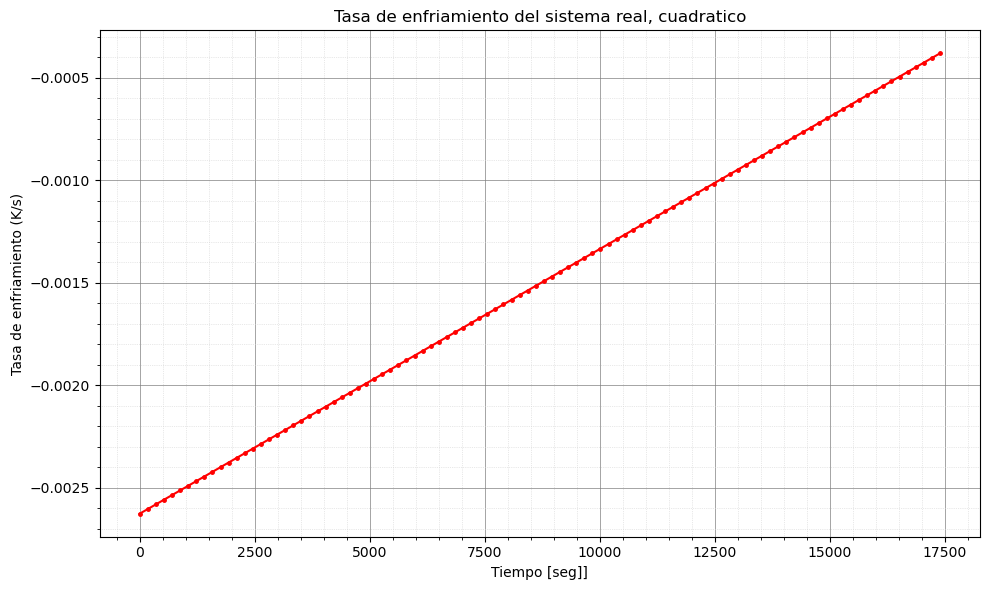

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(tiempo_en_seg, tasa_enfriamiento_cuadratica, color='red', linestyle='-', marker='.', markersize=5)
plt.xlabel("Tiempo [seg]]")
plt.ylabel("Tasa de enfriamiento (K/s)") 
plt.title("Tasa de enfriamiento del sistema real, cuadratico")
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray') 
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout()
plt.show()

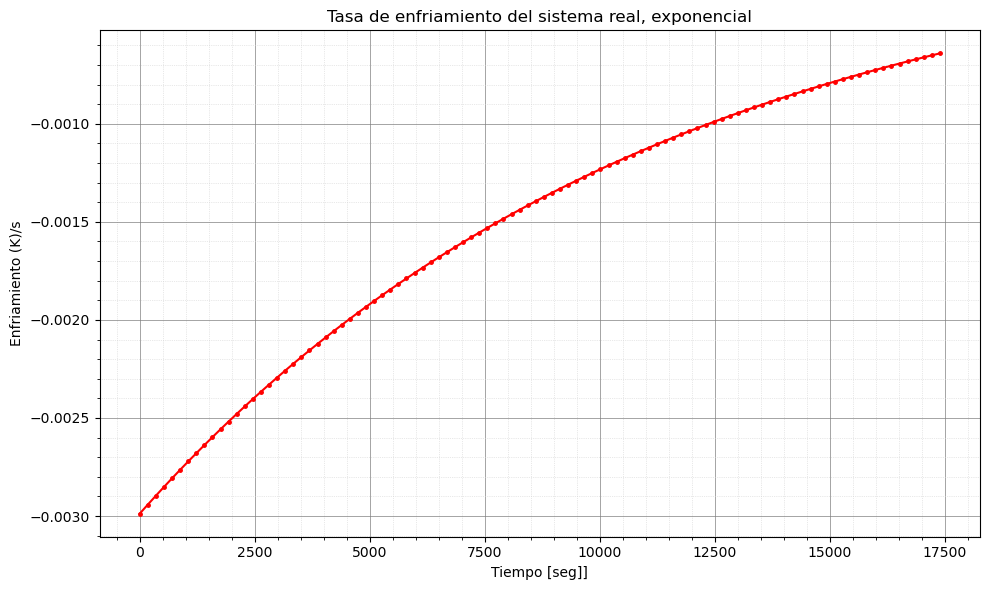

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(tiempo_en_seg, tasa_enfriamiento_exponencial, color='red', linestyle='-', marker='.', markersize=5)
plt.xlabel("Tiempo [seg]]")
plt.ylabel("Enfriamiento (K)/s") 
plt.title("Tasa de enfriamiento del sistema real, exponencial")
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray') 
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout()
plt.show()

##### El calor que esta perdiendo la leche deberia ser de la siguiente forma

In [26]:
def get_cp_milk(T_C, fat_percent):
    """
    Calcula la capacidad calorífica específica aparente de la leche (J/kg·K)
    basado en la temperatura (T en °C) y el porcentaje de grasa (%).
    Se utilizan correlaciones polinómicas de grado 5 ajustadas para diferentes
    rangos de temperatura, asumiendo un porcentaje de grasa cercano al 3.5%.
    Devuelve cp en J/kg·K o None si la entrada está fuera del rango de T o
    si el porcentaje de grasa no es ~3.5%.
    """
    cp_J_gK = None # Inicializar como None
    T = T_C        # Usar T en las ecuaciones por claridad

    # --- Verificar porcentaje de grasa (solo se tienen ecuaciones para ~3.5%) ---
    # Se mantiene la lógica original: estas ecuaciones son para ~3.5% de grasa.
    if abs(fat_percent - 3.5) < 0.1: # Tolerancia para punto flotante

        # --- Correlaciones Polinómicas de Grado 5 (Cp en J/g·K, T en °C) ---
        # Coeficientes: [a5, a4, a3, a2, a1, a0] para a5*T**5 + ... + a0

        if 0 <= T < 10:
            # Intervalo [0-10)
            cp_J_gK = (1.76658466e-05 * (T**5) - 4.58836819e-04 * (T**4) + 4.04370224e-03 * (T**3)
                       - 1.30139780e-02 * (T**2) + 1.33604567e-02 * T + 4.01576359e+00)
        elif 10 <= T < 20:
            # Intervalo [10-20)
            cp_J_gK = (6.22034295e-06 * (T**5) - 4.39825638e-04 * (T**4) + 1.20323308e-02 * (T**3)
                       - 1.58521777e-01 * (T**2) + 1.01058292e+00 * T + 1.55586850e+00)
        elif 20 <= T < 30:
            # Intervalo [20-30)
            cp_J_gK = (8.57989556e-06 * (T**5) - 1.11106869e-03 * (T**4) + 5.72799853e-02 * (T**3)
                       - 1.46758410e+00 * (T**2) + 1.86524283e+01 * T - 8.97892159e+01)
        elif 30 <= T < 40:
            # Intervalo [30-40)
            cp_J_gK = (3.70894294e-08 * (T**5) - 1.22027288e-05 * (T**4) + 1.48337059e-03 * (T**3)
                       - 8.22247585e-02 * (T**2) + 2.10691612e+00 * T - 1.62358505e+01)
        # else: # T fuera del rango [0, 40) -> cp_J_gK sigue siendo None

    # --- Manejo de Errores / Advertencias (dentro de la función) ---
    if cp_J_gK is None:
        # No emitir advertencia aquí directamente, devolver None para que la función que llama decida
        # warnings.warn(...)
        return None
    elif cp_J_gK <= 0:
        warnings.warn(f"Cp calculado es no positivo ({cp_J_gK:.3f} J/gK) para T_C={T_C:.1f}, fat={fat_percent}%. "
                      f"Devolviendo None.", stacklevel=3) # Nivel 3 porque se llama desde run_cooling_simulation
        return None
    else:
        # Convertir de J/g·K a J/kg·K
        return cp_J_gK * 1000.0

In [27]:
# ==============================================================
# CÁLCULO DE PÉRDIDA DE CALOR CON CP DINÁMICO
# ==============================================================

# --- Calcular Q_perdida_leche_cuad con Cp dinámico ---
Q_perdida_leche_cuad_temp = [] # Lista temporal
cp_leche_usado_cuad = []
warned_about_cp_cuad = False

for i in range(len(tiempo_en_seg)):
    T_leche_K = resultado_cuad_func_K[i] # Usar array de ajuste cuadrático
    T_leche_C = T_leche_K - 273.15
    cp_leche_dinamico = get_cp_milk(T_leche_C, fat_percent)

    if cp_leche_dinamico is None:
        if not warned_about_cp_cuad:
             warnings.warn(f"[Cuadrático] No se pudo calcular Cp dinámico a T={T_leche_C:.1f}C. "
                           f"Usando fallback {calor_especifico_leche:.1f} J/kg·K.", stacklevel=1)
             warned_about_cp_cuad = True
        cp_actual = calor_especifico_leche # Usar fallback
    else:
        cp_actual = cp_leche_dinamico

    cp_leche_usado_cuad.append(cp_actual)
    # Calcular Q perdida (Potencia en W) para este instante
    Q_perdida_instante = masa_leche * cp_actual * tasa_enfriamiento_cuadratica[i] # Usar tasa cuadrática
    Q_perdida_leche_cuad_temp.append(Q_perdida_instante)

# Convertir lista temporal a array NumPy con el nombre final deseado
Q_perdida_leche_cuad = np.array(Q_perdida_leche_cuad_temp)
cp_leche_usado_cuad = np.array(cp_leche_usado_cuad)

# --- Calcular Q_perdida_leche_exp con Cp dinámico ---
Q_perdida_leche_exp_temp = [] # Lista temporal
cp_leche_usado_exp = []
warned_about_cp_exp = False

for i in range(len(tiempo_en_seg)):
    T_leche_K = resultado_exp_func_K[i] # Usar array de ajuste exponencial
    T_leche_C = T_leche_K - 273.15
    cp_leche_dinamico = get_cp_milk(T_leche_C, fat_percent)

    if cp_leche_dinamico is None:
        if not warned_about_cp_exp:
             warnings.warn(f"[Exponencial] No se pudo calcular Cp dinámico a T={T_leche_C:.1f}C. "
                           f"Usando fallback {calor_especifico_leche:.1f} J/kg·K.", stacklevel=1)
             warned_about_cp_exp = True
        cp_actual = calor_especifico_leche # Usar fallback
    else:
        cp_actual = cp_leche_dinamico

    cp_leche_usado_exp.append(cp_actual)
    # Calcular Q perdida (Potencia en W) para este instante
    Q_perdida_instante = masa_leche * cp_actual * tasa_enfriamiento_exponencial[i] # Usar tasa exponencial
    Q_perdida_leche_exp_temp.append(Q_perdida_instante)

# Convertir lista temporal a array NumPy con el nombre final deseado
Q_perdida_leche_exp = np.array(Q_perdida_leche_exp_temp)
cp_leche_usado_exp = np.array(cp_leche_usado_exp)



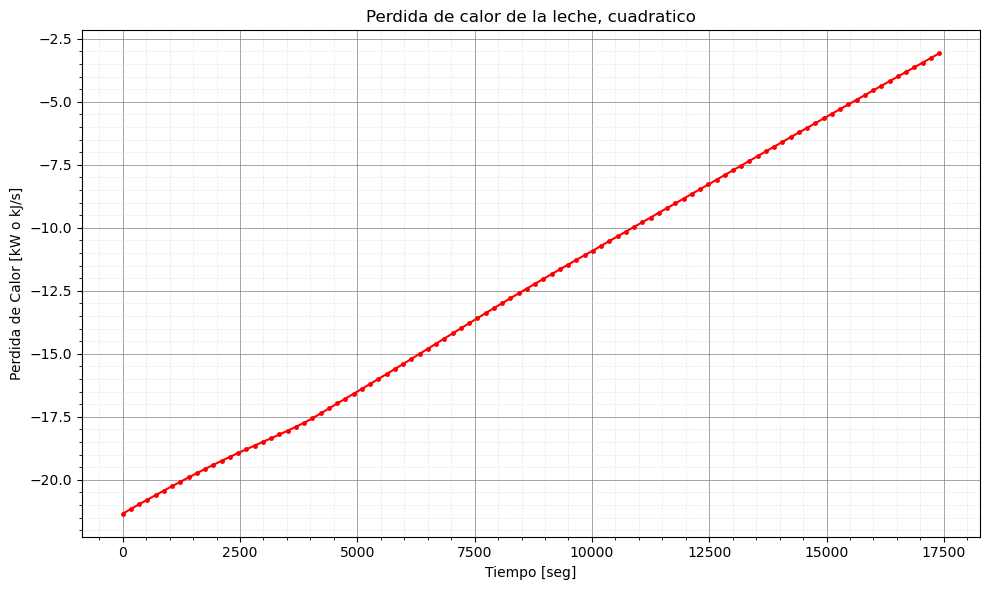

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(tiempo_en_seg, Q_perdida_leche_cuad/1000, color='red', linestyle='-', marker='.', markersize=5)
plt.xlabel("Tiempo [seg]")
plt.ylabel("Perdida de Calor [kW o kJ/s]") 
plt.title("Perdida de calor de la leche, cuadratico")
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray') 
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout()
plt.show()

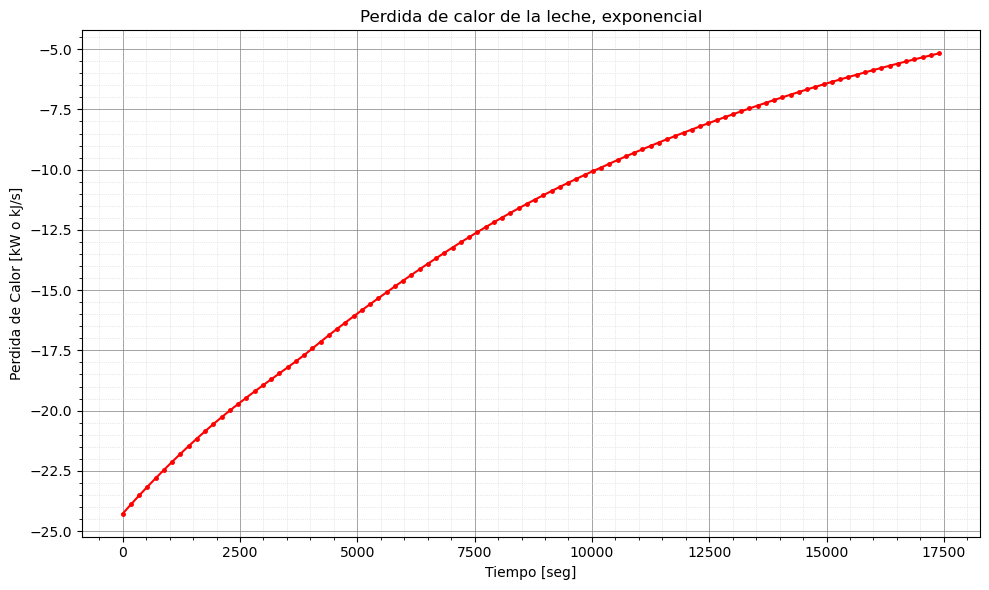

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(tiempo_en_seg, Q_perdida_leche_exp/1000, color='red', linestyle='-', marker='.', markersize=5)
plt.xlabel("Tiempo [seg]")
plt.ylabel("Perdida de Calor [kW o kJ/s]") 
plt.title("Perdida de calor de la leche, exponencial")
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray') 
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout()
plt.show()

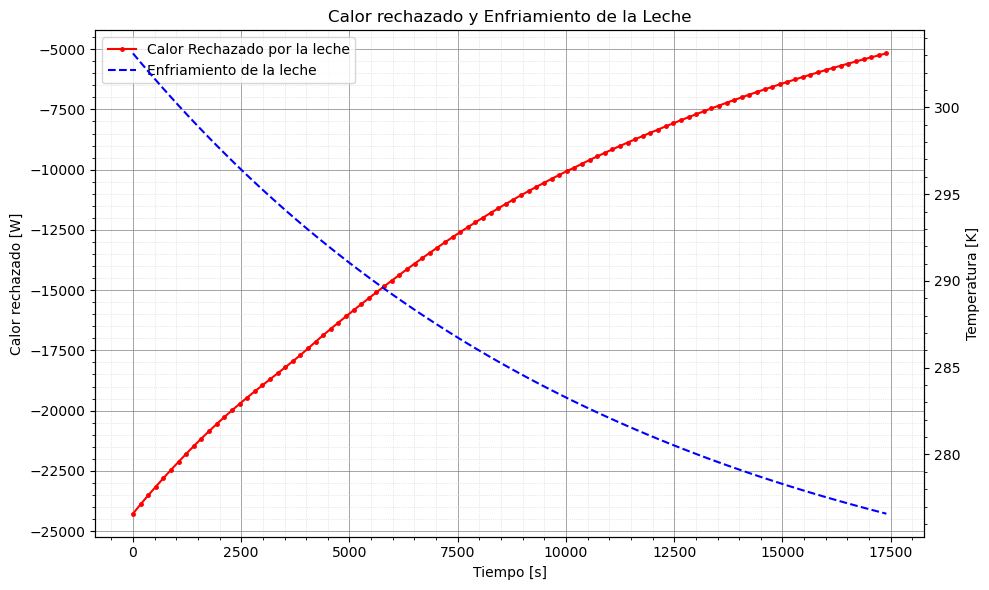

In [30]:
# 1. Crear la figura y el primer conjunto de ejes (ax1)
fig, ax1 = plt.subplots(figsize=(10, 6))

# 2. Configurar el primer eje (izquierdo) para Q_rechazado_leche
color_q = 'red'
ax1.set_xlabel("Tiempo [s]") 
ax1.set_ylabel("Calor rechazado [W]")
line1 = ax1.plot(tiempo_en_seg, Q_perdida_leche_exp, color=color_q, linestyle='-', marker='.', markersize=5, label='Calor Rechazado por la leche')
ax1.tick_params(axis='y')
ax1.minorticks_on()
ax1.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')

# 3. Crear el segundo conjunto de ejes (ax2) que comparte el eje X con ax1
ax2 = ax1.twinx()

# 4. Configurar el segundo eje (derecho) para tasa_de_enfriamiento_derivada
color_tasa = 'blue'
ax2.set_ylabel("Temperatura [K]")
line2 = ax2.plot(tiempo_en_seg, resultado_exp_func_K, color=color_tasa, linestyle='--', label='Enfriamiento de la leche') 
ax2.tick_params(axis='y')
ax2.minorticks_on()

# 5. Añadir título general
plt.title("Calor rechazado y Enfriamiento de la Leche")

# 6. Crear una leyenda combinada para ambos plots
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

# 7. Ajustar el layout para evitar solapamientos
fig.tight_layout() # Es mejor llamar a tight_layout() en la figura

# 8. Mostrar el gráfico
plt.show()

##### Ahora estimando las perdidas con el ambiente

In [31]:
# Convertir temperaturas a Kelvin
T_leche_inicial_K = T_leche_inicial + 273.15
T_leche_final_K = T_leche_final+ 273.15
T_ambiente_K = T_ambiente + 273.15

# Cambio de temperatura leche
DeltaT_leche_K = T_leche_inicial_K - T_leche_final_K # K

# *** CÁLCULO DE U CONSIDERANDO TODAS LAS RESISTENCIAS ***
try:
    R_conv_int = 1.0 / h_int               # Resistencia convección interna
    R_cond_acero = e_acero / k_acero     # Resistencia conducción acero
    R_cond_pur = e_pur / k_pur           # Resistencia conducción PUR
    R_conv_ext = 1.0 / h_ext               # Resistencia convección externa

    R_total = R_conv_int + R_cond_acero + R_cond_pur + R_conv_ext # Resistencia total
    U_completo = 1.0 / R_total             # Coeficiente global W/(m^2.K)
except ZeroDivisionError:
    U_completo = 0
    print("Advertencia: División por cero en cálculo de U (revisar h_int, k_*, h_ext)")
# **********************************************************

# Temperatura promedio de la leche en K
T_leche_avg_K = (T_leche_inicial_K + T_leche_final_K) / 2.0 # K

# Potencia promedio de intercambio de calor con el ambiente (W)
# (Negativo indica pérdida de calor hacia el ambiente)
Q_dot_ganancia_ambiente_avg= U_completo * A_externa * (T_ambiente_K - T_leche_avg_K) # W

print(f'La perdida de calor con el ambiente se estima en {Q_dot_ganancia_ambiente_avg} W')
print(U_completo * A_externa )

La perdida de calor con el ambiente se estima en -13.119262049775397 W
3.4524373815198826


###  <center> Teniendo esto en cuenta, podemos obtener la carga del evaporador

In [32]:
Q_evap_cuad = (-Q_perdida_leche_cuad) + Q_dot_ganancia_ambiente_avg


#Se cambia el nombre de Q_evap_exp a Q_in ya que se conoce que el comportamiento real debe estar mas cercano al ajuste exponencial 
Q_in = (-Q_perdida_leche_exp) + Q_dot_ganancia_ambiente_avg

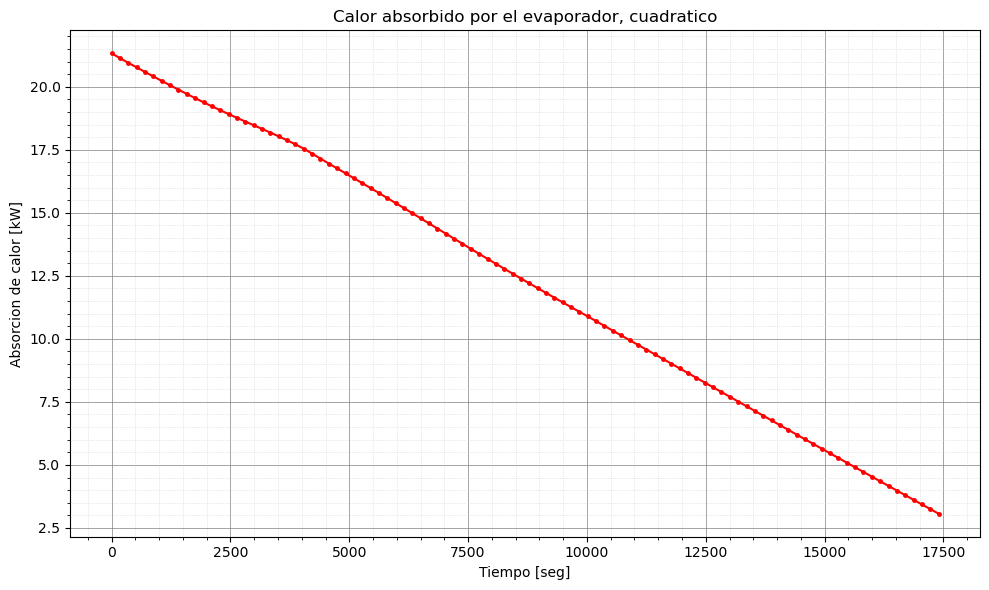

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(tiempo_en_seg, Q_evap_cuad/1000, color='red', linestyle='-', marker='.', markersize=5)
plt.xlabel("Tiempo [seg]")
plt.ylabel("Absorcion de calor [kW]") 
plt.title("Calor absorbido por el evaporador, cuadratico")
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray') 
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout()
plt.show()

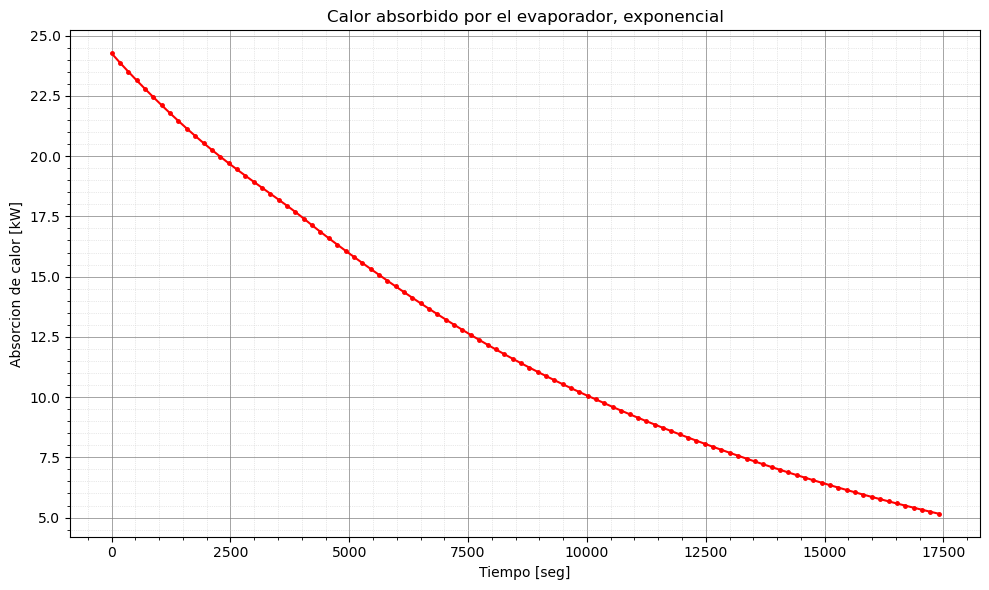

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(tiempo_en_seg, Q_in/1000, color='red', linestyle='-', marker='.', markersize=5)
plt.xlabel("Tiempo [seg]")
plt.ylabel("Absorcion de calor [kW]") 
plt.title("Calor absorbido por el evaporador, exponencial")
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray') 
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout()
plt.show()

###  <center>Estimando el COP obtenido del sistema

##### Necesitamos primero la potencia de entrada del sistema

In [35]:
nom = 'archivo_filtrado.csv'
df_filtrado=pd.read_csv(nom)
df_filtrado = df_filtrado.drop(columns=['Unnamed: 41'])
Potencia_real_compresor = df_filtrado['Potencia_Total_kW']


In [36]:
nuevo_indice = np.linspace(Potencia_real_compresor.index.min(), Potencia_real_compresor.index.max(), 100)

indice_combinado = Potencia_real_compresor.index.union(pd.Index(nuevo_indice)).sort_values()
serie_reindexada = Potencia_real_compresor.reindex(indice_combinado)

serie_interpolada = serie_reindexada.interpolate(method='linear')

w_dot_in = serie_interpolada.loc[nuevo_indice]
w_dot_in = w_dot_in.to_numpy()

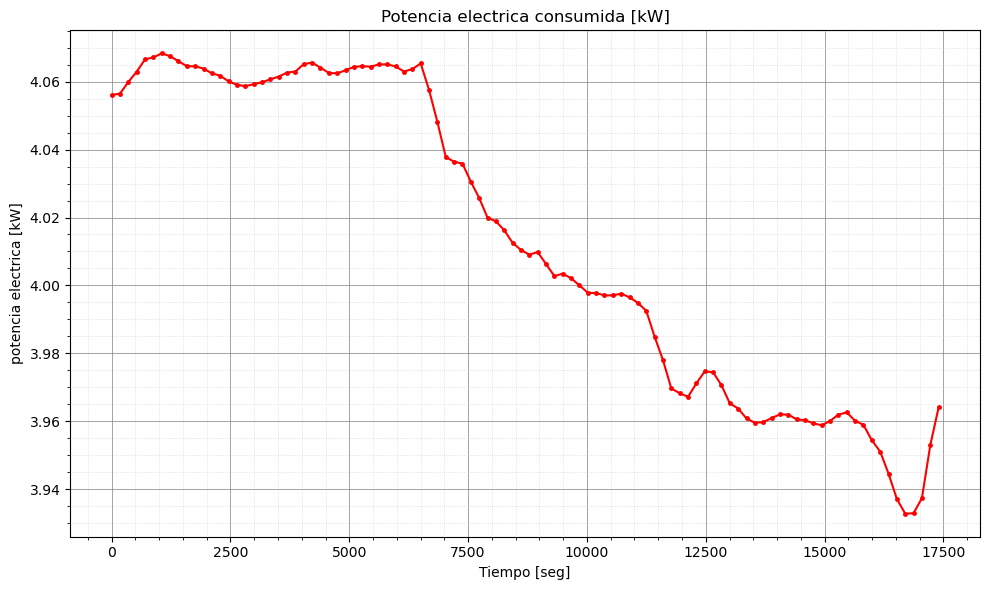

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(tiempo_en_seg, w_dot_in, color='red', linestyle='-', marker='.', markersize=5)
plt.xlabel("Tiempo [seg]")
plt.ylabel("potencia electrica [kW]") 
plt.title("Potencia electrica consumida [kW]")
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray') 
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout()
plt.show()

In [38]:
COP_cuad = (Q_evap_cuad/1000)/w_dot_in
COP_exp = (Q_in/1000)/w_dot_in

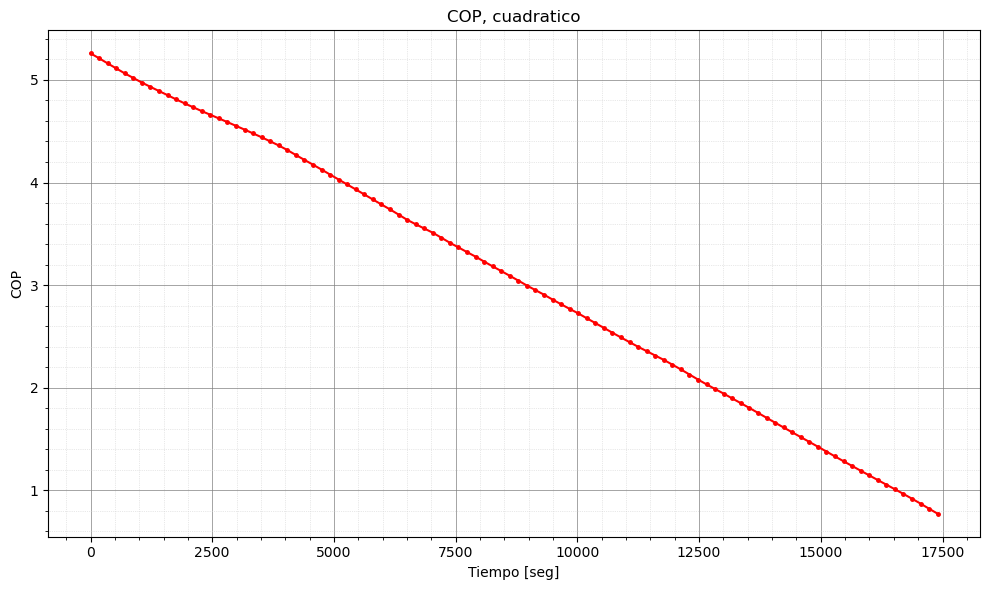

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(tiempo_en_seg, COP_cuad, color='red', linestyle='-', marker='.', markersize=5)
plt.xlabel("Tiempo [seg]")
plt.ylabel("COP") 
plt.title("COP, cuadratico")
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray') 
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout()
plt.show()

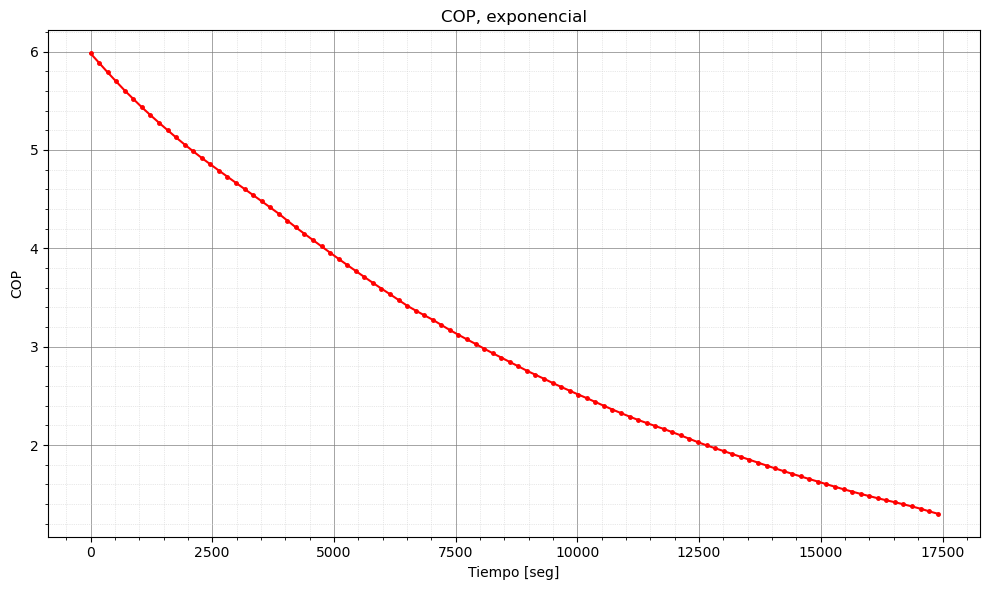

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(tiempo_en_seg, COP_exp, color='red', linestyle='-', marker='.', markersize=5)
plt.xlabel("Tiempo [seg]")
plt.ylabel("COP") 
plt.title("COP, exponencial")
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray') 
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout()
plt.show()

##### Con esto definitivamente podemos confirmar que el modelo mas cercano a la realidad es el exponecial

#### <center> Hecho esto, para poder estimar el funcionamiento del ciclo, debemos definir las condiciones de operacion

##### Inicialmente, haciendo un balance de energía de todo el sistema podemos obtener Q_out

In [41]:
Q_out = Q_in + (w_dot_in*1000) #W

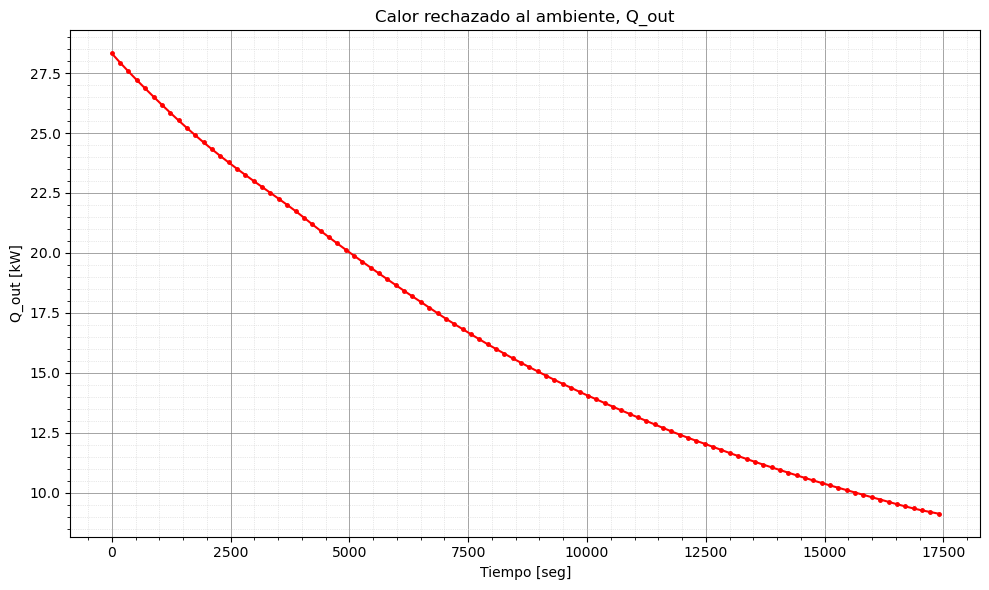

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(tiempo_en_seg, Q_out/1000 , color='red', linestyle='-', marker='.', markersize=5)
plt.xlabel("Tiempo [seg]")
plt.ylabel("Q_out [kW]") 
plt.title("Calor rechazado al ambiente, Q_out")
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray') 
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout()
plt.show()

#### Con esto, se hacen iteraciones para encontrar las temperaturas que cumplan con los valores conocidos

In [43]:

# --- Configuration Settings ---
# Encapsulate settings for easier modification
config = {
    # Solver Settings
    "solver_tolerance_xtol": 1.49012e-08, # Tolerance on variable change
    "solver_tolerance_ftol": 1e-8,       # Tolerance on function value change (sum of squares)
    "solver_tolerance_gtol": 1e-8,       # Tolerance on gradient norm
    "max_retries": 5,                    # Max initial guesses to try per target
    "target_relative_error_max": 0.05,   # 5% target relative error for success

    # Refrigerant and Cycle Model Parameters
    "refrigerant": 'R22', # *** CONFIGURADO PARA R22 ***
    "compressor_efficiency": 0.75, # Isentropic efficiency (set to 1.0 for isentropic)
    "evaporator_superheat_K": 5.0,   # Superheating in Kelvin
    "condenser_subcooling_K": 3.0,   # Subcooling in Kelvin (set to 0 for saturated)

    # Parallel Processing
    "n_parallel_jobs": -1, # Use all available CPU cores (-1)

    # Logging
    "log_level": logging.INFO, # logging.DEBUG for more detail, logging.WARNING for less
    "log_file": "inverse_cycle_solver_R22_with_T4_and_Exp.log", # Set to None to log only to console <-- Updated log file name

    # Bounds for Solver Variables [T_evap_K, T_cond_K, m_dot_kgs]
    # MUST be adjusted based on the refrigerant!
    "solver_bounds": {
        'R22': ([233.0, 273.0, 1e-4], [293.0, 343.0, 1.0]), # R22 bounds: Tevap [-40C to 20C], Tcond [0C to 70C]. Ajusta según necesidad.
        'R744': ([220.0, 260.0, 1e-4], [280.0, 350.0, 1.0]), # CO2 example bounds
    },

     # Initial Guess Generation
     "base_initial_guess": [263.0, 313.0, 0.05], # Base guess for R22 [Tevap -10C, Tcond 40C, mdot=0.05]. Ajusta si es necesario.
     "guess_temp_variations_K": [-8, 8, -15, 15],
     "guess_mdot_factors": [0.7, 1.3, 0.5, 1.5],
}

# --- Logging Setup ---
log_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
# Remove existing handlers if any (useful for re-runs in interactive environments)
for handler in logger.handlers[:]:
    logger.removeHandler(handler)
logger.setLevel(config["log_level"])

# Console Handler
stream_handler = logging.StreamHandler(sys.stdout)
stream_handler.setFormatter(log_formatter)
logger.addHandler(stream_handler)

# File Handler (Optional)
if config["log_file"]:
    try:
        file_handler = logging.FileHandler(config["log_file"], mode='w') # Overwrite log file each run
        file_handler.setFormatter(log_formatter)
        logger.addHandler(file_handler)
        logging.info(f"Logging to file: {config['log_file']}")
    except Exception as e:
        logging.error(f"Could not set up file logging: {e}")

# --- Thermodynamic Cycle Calculation Class ---
class ThermodynamicCycleCalculator:
    """Calculates properties of a vapor-compression cycle."""
    def __init__(self, ref: str, eta_comp: float, sh_K: float, sc_K: float):
        self.ref = ref
        self.eta_comp = eta_comp
        self.sh_K = sh_K
        self.sc_K = sc_K
        try:
            self.T_crit_K = CP.PropsSI('Tcrit', self.ref)
            self.P_crit_Pa = CP.PropsSI('Pcrit', self.ref)
            self.T_triple_K = CP.PropsSI('Ttriple', self.ref)
            logging.debug(f"Cycle Calculator initialized for {ref}: eta={eta_comp}, sh={sh_K}K, sc={sc_K}K")
            logging.debug(f"Critical Point: T={self.T_crit_K:.2f}K, P={self.P_crit_Pa/1e6:.3f}MPa. Triple Point T={self.T_triple_K:.2f}K")
        except ValueError as e:
            logging.error(f"Could not get critical/triple point properties for refrigerant '{ref}': {e}")
            raise # Re-raise the error to stop execution if basic props fail


    def calculate_properties(self, T_evap_K: float, T_cond_K: float, m_dot_kgs: float) -> dict | None:
        """
        Calculates cycle properties for given operating conditions.
        Returns a dictionary with results or None if calculation fails.
        """
        try:
            # Basic physical checks
            if not (self.T_triple_K < T_evap_K < self.T_crit_K - 0.1):
                 logging.debug(f"Calc Error: T_evap_K ({T_evap_K:.1f}) out of range ({self.T_triple_K:.1f}K - {self.T_crit_K-0.1:.1f}K)")
                 return None
            if not (T_evap_K < T_cond_K < self.T_crit_K - 0.1): # Ensure subcritical condensation for R22 common model
                 logging.debug(f"Calc Error: T_cond_K ({T_cond_K:.1f}) out of subcritical range or not > T_evap_K ({T_evap_K:.1f})")
                 return None
            if T_cond_K <= T_evap_K + max(self.sh_K, self.sc_K, 2.0):
                 logging.debug(f"Calc Error: T_cond_K ({T_cond_K:.1f}) too close to T_evap_K ({T_evap_K:.1f})")
                 return None
            if m_dot_kgs <= 0:
                 logging.debug(f"Calc Error: m_dot_kgs ({m_dot_kgs:.4e}) must be positive")
                 return None

            # State 1: Evaporator Outlet / Compressor Inlet (Superheated)
            P1_Pa = CP.PropsSI('P', 'T', T_evap_K, 'Q', 1, self.ref)
            T1_K = T_evap_K + self.sh_K
            h1 = CP.PropsSI('H', 'T', T1_K, 'P', P1_Pa, self.ref)
            s1 = CP.PropsSI('S', 'T', T1_K, 'P', P1_Pa, self.ref)

            # State 3: Condenser Outlet / Expansion Valve Inlet (Subcooled)
            P3_Pa = CP.PropsSI('P', 'T', T_cond_K, 'Q', 0, self.ref)
            T3_K = T_cond_K - self.sc_K
            if T3_K <= T_evap_K:
                 logging.debug(f"Calc Error: T3_K ({T3_K:.1f}) is not > T_evap_K ({T_evap_K:.1f})")
                 return None
            h3 = CP.PropsSI('H', 'T', T3_K, 'P', P3_Pa, self.ref)

            # State 2: Compressor Outlet
            P2_Pa = P3_Pa
            s2s = s1
            h2s = CP.PropsSI('H', 'P', P2_Pa, 'S', s2s, self.ref)
            h2 = h1 + (h2s - h1) / self.eta_comp
            T2_K = CP.PropsSI('T', 'P', P2_Pa, 'H', h2, self.ref)

            # State 4: Expansion Valve Outlet / Evaporator Inlet
            P4_Pa = P1_Pa
            h4 = h3

            # *** Calcular T4 explícitamente ***
            try:
                 # Típicamente T4 será igual a T_evap_K porque es una mezcla a P_evap
                 T4_K = CP.PropsSI('T', 'P', P4_Pa, 'H', h4, self.ref)
            except ValueError:
                 # Fallback si CoolProp falla cerca de la saturación
                 T4_K = T_evap_K
                 logging.debug(f"Could not calculate T4 directly, using T_evap_K ({T_evap_K:.2f}) as T4_K")
                 # Podríamos incluso añadir una verificación de calidad aquí si quisiéramos:
                 # Q4 = CP.PropsSI('Q','P', P4_Pa, 'H', h4, self.ref) -> debería estar entre 0 y 1

            # Calculated Performance
            Q_evap_calc = m_dot_kgs * (h1 - h4)
            W_comp_calc = m_dot_kgs * (h2 - h1)
            Q_cond_calc = m_dot_kgs * (h2 - h3)

            # Validation Checks
            if Q_evap_calc <= 0 or W_comp_calc <= 0:
                 logging.debug(f"Calc Error: Non-positive Q_evap ({Q_evap_calc:.1f}) or W_comp ({W_comp_calc:.1f}) calculated.")
                 return None
            if not np.isclose(Q_cond_calc, Q_evap_calc + W_comp_calc, rtol=1e-3):
                 logging.warning(f"Energy balance mismatch: Qcond={Q_cond_calc:.1f}, Qevap+Wcomp={Q_evap_calc + W_comp_calc:.1f}. Delta={(Q_evap_calc + W_comp_calc)-Q_cond_calc:.1f}")

            # *** Añadir T4_K al diccionario de resultados ***
            return {
                 "T_evap_K": T_evap_K, "T_cond_K": T_cond_K, "m_dot_kgs": m_dot_kgs,
                 "Q_evap_calc": Q_evap_calc, "W_comp_calc": W_comp_calc, "Q_cond_calc": Q_cond_calc,
                 "T1_K": T1_K, "T2_K": T2_K, "T3_K": T3_K, "T4_K": T4_K, # <-- T4 ADDED HERE
                 "h1": h1, "h2": h2, "h3": h3, "h4": h4, "s1": s1,
                 "P_evap_Pa": P1_Pa, "P_cond_Pa": P2_Pa,
            }

        except ValueError as e:
            logging.debug(f"CoolProp ValueError during calculation for T_evap={T_evap_K:.1f}, T_cond={T_cond_K:.1f}, m_dot={m_dot_kgs:.4e}: {e}")
            return None
        except Exception as e:
            logging.error(f"Unexpected error during calculation: {e}", exc_info=True)
            return None

# --- System Equations for Solver (Uses Calculator Instance) ---
def system_equations_relative(variables, calculator: ThermodynamicCycleCalculator, targets: tuple):
    """
    Calculates relative errors between calculated and target performance.
    Used by least_squares.
    """
    T_evap_K, T_cond_K, m_dot_kgs = variables
    Q_evap_target, W_comp_target, Q_cond_target = targets
    epsilon = 1e-9 # To avoid division by zero

    results = calculator.calculate_properties(T_evap_K, T_cond_K, m_dot_kgs)

    if results is None:
        # Return large errors if calculation fails to guide solver away
        return [1e6, 1e6, 1e6]

    diff_Q_evap_rel = (results['Q_evap_calc'] - Q_evap_target) / (abs(Q_evap_target) + epsilon)
    diff_W_comp_rel = (results['W_comp_calc'] - W_comp_target) / (abs(W_comp_target) + epsilon)
    diff_Q_cond_rel = (results['Q_cond_calc'] - Q_cond_target) / (abs(Q_cond_target) + epsilon)

    errors = [diff_Q_evap_rel, diff_W_comp_rel, diff_Q_cond_rel]

    if any(math.isnan(e) for e in errors):
        logging.warning(f"NaN detected in errors for variables: {variables}")
        return [1e6, 1e6, 1e6] # Return large errors for NaN

    return errors

# --- Initial Guess Generation (Respecting Bounds) ---
def generate_initial_guesses(base_guess: list, bounds: tuple, num_guesses: int = 5):
    """Generates a list of initial estimates varying the base, respecting bounds."""
    guesses = []
    lower_bounds, upper_bounds = bounds
    # Ensure base guess respects bounds from the start
    base_guess_bounded = np.clip(base_guess, lower_bounds, upper_bounds)
    guesses.append(list(base_guess_bounded))
    if num_guesses <= 1: return guesses

    T_evap_base, T_cond_base, m_dot_base = base_guess_bounded
    np.random.seed(int(time.time())) # Seed for variability in random part
    temp_variations = config["guess_temp_variations_K"]
    mdot_factors = config["guess_mdot_factors"]
    count = 1

    # Systematic variations first
    for dt_evap in temp_variations:
        if count >= num_guesses: break
        new_guess = np.clip([T_evap_base + dt_evap, T_cond_base, m_dot_base], lower_bounds, upper_bounds)
        if not any(np.allclose(new_guess, g, atol=1e-2) for g in guesses): # Avoid near duplicates
            guesses.append(list(new_guess)); count += 1
    for dt_cond in temp_variations:
        if count >= num_guesses: break
        new_guess = np.clip([T_evap_base, T_cond_base + dt_cond, m_dot_base], lower_bounds, upper_bounds)
        if not any(np.allclose(new_guess, g, atol=1e-2) for g in guesses):
            guesses.append(list(new_guess)); count += 1
    for m_factor in mdot_factors:
        if count >= num_guesses: break
        new_guess = np.clip([T_evap_base, T_cond_base, m_dot_base * m_factor], lower_bounds, upper_bounds)
        if not any(np.allclose(new_guess, g, atol=1e-2) for g in guesses):
            guesses.append(list(new_guess)); count += 1

    # Fill remaining slots with random guesses within bounds
    while count < num_guesses:
        t_evap_new = np.random.uniform(lower_bounds[0], upper_bounds[0])
        # Ensure T_cond is reasonably higher than T_evap
        t_cond_new = np.random.uniform(max(t_evap_new + 5, lower_bounds[1]), upper_bounds[1])
        m_dot_new = np.random.uniform(lower_bounds[2], upper_bounds[2]*0.5) # Bias towards lower end? Adjust if needed
        new_guess = [t_evap_new, t_cond_new, m_dot_new]
        if not any(np.allclose(new_guess, g, atol=1e-2) for g in guesses):
            guesses.append(new_guess); count += 1

    logging.debug(f"Generated {len(guesses)} initial guesses.")
    return guesses


# --- Inverse Cycle Solver Class ---
class InverseCycleSolver:
    """
    Solves for cycle parameters (T_evap, T_cond, m_dot) to match target Q_evap, W_comp, Q_cond.
    Uses least_squares with retries and bounds.
    """
    def __init__(self, config: dict):
        self.config = config
        self.ref = config["refrigerant"]
        self.calculator = ThermodynamicCycleCalculator(
            ref=self.ref,
            eta_comp=config["compressor_efficiency"],
            sh_K=config["evaporator_superheat_K"],
            sc_K=config["condenser_subcooling_K"]
        )
        try:
            self.bounds = config["solver_bounds"][self.ref]
            logging.info(f"Using bounds for {self.ref}: {self.bounds}")
        except KeyError:
            logging.error(f"Bounds not defined for refrigerant '{self.ref}' in config['solver_bounds']. Exiting.")
            raise ValueError(f"Missing bounds for {self.ref}")
        self.base_initial_guess = config["base_initial_guess"]
        self.max_retries = config["max_retries"]
        self.target_rel_err = config["target_relative_error_max"]

    def _validate_targets(self, q_evap: float, w_comp: float, q_cond: float) -> bool:
        """Perform basic plausibility checks on target values."""
        valid = True
        if w_comp <= 0: logging.warning(f"Target Validation: W_comp ({w_comp:.1f}) must be positive."); valid = False
        if q_evap <= 0: logging.warning(f"Target Validation: Q_evap ({q_evap:.1f}) is non-positive.") # Might be valid for some apps, but unusual
        expected_q_cond = q_evap + w_comp
        # Allow slightly larger tolerance for target validation
        if not np.isclose(q_cond, expected_q_cond, rtol=0.1):
             logging.warning(f"Target Validation: Energy balance mismatch. Q_cond_target={q_cond:.1f}, Q_evap+W_comp={expected_q_cond:.1f}.")
             # valid = False # Decide if this mismatch should prevent solving
        return valid

    # MODIFIED: Added res_exp_k_target argument
    def _optimize_single_target(self, target_idx: int, q_target: float, w_target: float, qc_target: float, res_exp_k_target: float) -> dict:
        """Runs least_squares for a single target set, retrying with multiple initial guesses."""
        targets = (q_target, w_target, qc_target)
        # Optional: Include new target in log prefix for clarity
        log_prefix = f"Target {target_idx+1} [Qe={q_target:.0f}, Wc={w_target:.0f}, Qc={qc_target:.0f}, ResExp={res_exp_k_target:.1f}]"

        # MODIFIED: Added resultado_exp_func_K to base failure dict
        base_fail_result = {
            'Target_Index': target_idx + 1, 'Solver_Success': False, 'Solver_Converged': False, 'Meets_Tolerance': False,
            'Combined_Rel_Err': float('inf'), 'Successful_Guess_Idx': -1,
            'Q_evap_Target': q_target, 'W_comp_Target': w_target, 'Q_cond_Target': qc_target,
            'resultado_exp_func_K': res_exp_k_target, # <-- ADDED HERE
            'Error_Message': None, 'Solver_Message': None, # Ensure these are present
             # Add placeholders for other columns expected in the final DataFrame
             'T_evap_K': np.nan, 'T_cond_K': np.nan, 'm_dot_kgs': np.nan,
             'Q_evap_calc': np.nan, 'W_comp_calc': np.nan, 'Q_cond_calc': np.nan,
             'T1_K': np.nan, 'T2_K': np.nan, 'T3_K': np.nan, 'T4_K': np.nan,
             'h1': np.nan, 'h2': np.nan, 'h3': np.nan, 'h4': np.nan, 's1': np.nan,
             'P_evap_Pa': np.nan, 'P_cond_Pa': np.nan,
             'DIF_Q_evap': np.nan, 'DIF_W_comp': np.nan, 'DIF_Q_cond': np.nan,
             'RelErr_Q_evap': np.nan, 'RelErr_W_comp': np.nan, 'RelErr_Q_cond': np.nan,
             'Solver_Status': -10, 'Successful_Guess': None, 'Solution_Variables': None
        }


        if not self._validate_targets(q_target, w_target, qc_target):
            logging.error(f"{log_prefix}: Targets failed validation.")
            base_fail_result['Error_Message'] = "Target values failed plausibility check."
            return base_fail_result

        initial_guesses = generate_initial_guesses(self.base_initial_guess, self.bounds, num_guesses=self.max_retries)
        logging.debug(f"{log_prefix}: Generated {len(initial_guesses)} guesses.")
        best_result_so_far = None
        min_combined_error = float('inf')
        final_solver_message = "No convergence attempted or all attempts failed."

        for attempt_idx, guess in enumerate(initial_guesses):
            logging.debug(f"{log_prefix}: Attempt {attempt_idx+1}/{len(initial_guesses)} with guess {np.round(guess, 2)}")
            try:
                # Suppress RuntimeWarning (e.g., divide by zero if targets are zero) during optimization step
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", RuntimeWarning)
                    ls_result = least_squares(system_equations_relative, x0=guess, args=(self.calculator, targets),
                                              bounds=self.bounds, ftol=self.config["solver_tolerance_ftol"],
                                              xtol=self.config["solver_tolerance_xtol"], gtol=self.config["solver_tolerance_gtol"],
                                              method='trf', verbose=0) # verbose=0 for less output

                solver_converged = ls_result.success # More reliable indicator than status > 0 for least_squares
                solution = ls_result.x
                final_solver_message = ls_result.message # Store last message

                logging.debug(f"{log_prefix}: Attempt {attempt_idx+1} - Converged: {solver_converged}, Status: {ls_result.status}, Msg: {ls_result.message}")

                # Check if solution seems valid (within bounds, positive m_dot) before final calculation
                if not (self.bounds[0][0] <= solution[0] <= self.bounds[1][0] and \
                        self.bounds[0][1] <= solution[1] <= self.bounds[1][1] and \
                        self.bounds[0][2] <= solution[2] <= self.bounds[1][2]):
                     logging.warning(f"{log_prefix}: Attempt {attempt_idx+1} - Solution {np.round(solution,3)} outside bounds {self.bounds}. Skipping.")
                     # Update best_result_so_far if this is the only thing we got? Maybe not.
                     continue # Try next guess

                T_evap_sol, T_cond_sol, m_dot_sol = solution
                current_cycle_result = self.calculator.calculate_properties(T_evap_sol, T_cond_sol, m_dot_sol)

                if current_cycle_result: # Check if calculation was successful
                    epsilon = 1e-9 # Avoid division by zero
                    q_evap_calc = current_cycle_result.get('Q_evap_calc', 0)
                    w_comp_calc = current_cycle_result.get('W_comp_calc', 0)
                    q_cond_calc = current_cycle_result.get('Q_cond_calc', 0)

                    err_q_evap_rel = abs(q_evap_calc - q_target) / (abs(q_target) + epsilon)
                    err_w_comp_rel = abs(w_comp_calc - w_target) / (abs(w_target) + epsilon)
                    err_q_cond_rel = abs(q_cond_calc - qc_target) / (abs(qc_target) + epsilon)
                    combined_err = err_q_evap_rel + err_w_comp_rel + err_q_cond_rel # Simple sum of relative errors

                    meets_tolerance = (err_q_evap_rel < self.target_rel_err and
                                       err_w_comp_rel < self.target_rel_err and
                                       err_q_cond_rel < self.target_rel_err)

                    # MODIFIED: Added resultado_exp_func_K to result dict
                    current_cycle_result.update({
                        'Target_Index': target_idx + 1, 'Q_evap_Target': q_target, 'W_comp_Target': w_target, 'Q_cond_Target': qc_target,
                        'resultado_exp_func_K': res_exp_k_target, # <-- ADDED HERE
                        'DIF_Q_evap': q_evap_calc - q_target, 'DIF_W_comp': w_comp_calc - w_target, 'DIF_Q_cond': q_cond_calc - qc_target,
                        'RelErr_Q_evap': err_q_evap_rel, 'RelErr_W_comp': err_w_comp_rel, 'RelErr_Q_cond': err_q_cond_rel, 'Combined_Rel_Err': combined_err,
                        'Solver_Success': True, 'Solver_Converged': solver_converged, 'Meets_Tolerance': meets_tolerance, 'Solver_Message': ls_result.message,
                        'Solver_Status': ls_result.status, 'Successful_Guess_Idx': attempt_idx, 'Successful_Guess': list(guess), 'Solution_Variables': list(solution), 'Error_Message': None
                    })

                    if meets_tolerance:
                        logging.info(f"{log_prefix}: Success on attempt {attempt_idx+1}. Meets tolerance.")
                        return current_cycle_result # Return the successful result immediately
                    else:
                        # Store this result if it's the best failure so far
                        if combined_err < min_combined_error:
                             logging.debug(f"{log_prefix}: Attempt {attempt_idx+1} - Best failure so far (Error sum: {combined_err:.4f}). Converged: {solver_converged}")
                             min_combined_error = combined_err
                             best_result_so_far = current_cycle_result # Keep the full dict
                             # Ensure the error message reflects why it's stored (failed tolerance)
                             best_result_so_far['Error_Message'] = f"Solver finished (Converged: {solver_converged}) but failed target tolerance."

                else: # Calculation returned None after a seemingly successful solve
                    logging.warning(f"{log_prefix}: Attempt {attempt_idx+1} - Solver finished (Converged: {solver_converged}) but cycle calculation failed for solution {np.round(solution,3)}.")
                    # Store a minimal failure dict if it's better than nothing
                    current_fail_dict = {
                        **base_fail_result, # Start with base structure
                        'Solver_Success': True, # Solver itself succeeded
                        'Solver_Converged': solver_converged,
                        'Successful_Guess_Idx': attempt_idx,
                        'Successful_Guess': list(guess),
                        'Solution_Variables': list(solution),
                        'Solver_Message': ls_result.message,
                        'Solver_Status': ls_result.status,
                        'Combined_Rel_Err': float('inf'), # High error since calc failed
                        'Error_Message': "Cycle calculation failed post-solve."
                        # Keep res_exp_k_target from base_fail_result
                    }
                    if best_result_so_far is None: # If we haven't stored any result yet
                         best_result_so_far = current_fail_dict
                         min_combined_error = float('inf') # Keep track that this has infinite error

            except Exception as e:
                 logging.error(f"{log_prefix}: Attempt {attempt_idx+1} - Exception during least_squares or post-processing: {e}", exc_info=False) # exc_info=False to reduce log noise, True for debug
                 final_solver_message = f"Exception: {e}" # Store exception message
                 # Store a minimal failure dict if it's better than nothing
                 current_fail_dict = {
                    **base_fail_result, # Start with base structure
                    'Solver_Success': False, # Indicate solver process failed here
                    'Solver_Converged': False,
                    'Successful_Guess_Idx': attempt_idx,
                    'Successful_Guess': list(guess),
                    'Error_Message': f"Exception during solve: {e}",
                    'Solver_Message': final_solver_message,
                    # Keep res_exp_k_target from base_fail_result
                 }
                 if best_result_so_far is None: # If we haven't stored any result yet
                     best_result_so_far = current_fail_dict
                     min_combined_error = float('inf') # Keep track that this has infinite error
                 continue # Try next guess even if one attempt raises an exception

        # --- End of retry loop ---
        if best_result_so_far:
            # This means we finished all attempts without meeting tolerance
            # Return the best result found (which might be from a converging solve or a minimal failure dict)
            log_message_end = f"{log_prefix}: Failed to meet tolerance after {len(initial_guesses)} attempts."
            if best_result_so_far.get('Solver_Success'): # If the best result came from a solver run (even if calc failed later)
                log_message_end += f" Returning best found result (Error sum: {best_result_so_far.get('Combined_Rel_Err', 'N/A'):.4f})."
            else: # If the best result was just a basic failure structure
                log_message_end += f" Returning minimal failure info. Last solver msg: {best_result_so_far.get('Solver_Message','N/A')}"

            logging.warning(log_message_end)
            best_result_so_far['Meets_Tolerance'] = False # Ensure flag is False
            # Ensure essential keys exist, filling with NaN or defaults if necessary
            # (base_fail_result should have covered most, but double-check)
            for key, default_val in base_fail_result.items():
                best_result_so_far.setdefault(key, default_val)
            return best_result_so_far
        else:
            # This means no attempt even yielded a minimal result dict (e.g., all raised exceptions immediately)
            logging.error(f"{log_prefix}: Failed. No attempt yielded any valid result structure. Last solver msg: {final_solver_message}")
            base_fail_result['Error_Message'] = "No attempt yielded a valid calculation or result dict."
            base_fail_result['Solver_Message'] = final_solver_message
            return base_fail_result

    # MODIFIED: Added resultado_exp_func_K_targets argument
    def solve_targets(self, Q_evap_targets, W_comp_targets, Q_cond_targets, resultado_exp_func_K_targets):
        """Solves for cycle parameters for multiple target sets in parallel."""
        num_targets = len(Q_evap_targets)
        # MODIFIED: Validate length of the new input array
        if not (num_targets == len(W_comp_targets) == len(Q_cond_targets) == len(resultado_exp_func_K_targets)):
            raise ValueError("Target arrays (Q_evap, W_comp, Q_cond, resultado_exp_func_K) must have the same length.")

        logging.info(f"Starting parallel optimization for {num_targets} targets using {self.config['n_parallel_jobs']} jobs.")
        start_time = time.time()

        # MODIFIED: Pass the corresponding resultado_exp_func_K value to each task
        tasks = [delayed(self._optimize_single_target)(i, Q_evap_targets[i], W_comp_targets[i], Q_cond_targets[i], resultado_exp_func_K_targets[i])
                 for i in range(num_targets)]

        # Run in parallel with progress bar
        results_list = Parallel(n_jobs=self.config["n_parallel_jobs"], backend="loky")(
            tqdm(tasks, desc="Optimizing Targets", total=num_targets, file=sys.stdout, unit="target")
        )

        end_time = time.time()
        logging.info(f"Parallel optimization finished in {end_time - start_time:.2f} seconds.")
        return results_list


# --- Main Execution ---
if __name__ == "__main__":
    logging.info(f"--- Starting Inverse Cycle Analysis ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")
    logging.info(f"Using Refrigerant: {config['refrigerant']}")
    logging.info(f"Model Params: eta={config['compressor_efficiency']}, sh={config['evaporator_superheat_K']}K, sc={config['condenser_subcooling_K']}K")
    logging.info(f"Target Relative Error: {config['target_relative_error_max']:.1%}")
    logging.info(f"Max Retries per Target: {config['max_retries']}")

    # --- Load or Define Target Data (Original Script Style) ---
    try:
        # These variables MUST be defined BEFORE running this script
        # if you want to use external data.
        # Ensure they are NumPy arrays or lists.
        Q_in = np.array(Q_in) # Watts
        w_dot_in = np.array(w_dot_in) # ASSUMES kW initially based on name
        Q_out = np.array(Q_out) # Watts
        # *** ADDITION: Assume resultado_exp_func_K is also pre-defined ***
        resultado_exp_func_K_data = np.array(resultado_exp_func_K) # Units: K (as per name)

        logging.info(f"Using pre-defined target variables Q_in, w_dot_in, Q_out, resultado_exp_func_K ({len(Q_in)} targets).")
        # Convert w_dot_in from kW to W
        logging.info("Converting w_dot_in from assumed kW to W.")
        w_dot_in = w_dot_in * 1000 # <-- Explicit conversion

    except NameError:
        logging.warning("Input variables (Q_in, w_dot_in, Q_out, resultado_exp_func_K) not pre-defined. Generating random example data.")
        num_examples = 50
        # Generate examples roughly consistent with R22 ranges
        Q_in = np.random.uniform(3000, 6000, num_examples) # Q_evap target (W)
        COP_est = np.random.uniform(2.8, 4.5, num_examples) # Estimated COP
        w_dot_in = Q_in / COP_est # W_comp target (W) <- Already in Watts here
        Q_out = Q_in + w_dot_in # Q_cond target (W)
        # *** ADDITION: Generate dummy data for the new variable ***
        # Example: Generate random temperatures around expected operating range
        resultado_exp_func_K_data = np.random.uniform(280, 320, num_examples) # Example: Kelvin

        logging.info(f"Generated {num_examples} random target sets.")

    # Assign to target variables used by the solver
    Q_evap_targets = Q_in
    W_comp_targets = w_dot_in # Already in Watts
    Q_cond_targets = Q_out
    # *** ADDITION: Assign the new target data ***
    Res_exp_K_targets = resultado_exp_func_K_data


    # --- Initialize and Run Solver ---
    try:
        solver = InverseCycleSolver(config)
        # MODIFIED: Pass the new target data array to solve_targets
        all_results = solver.solve_targets(Q_evap_targets, W_comp_targets, Q_cond_targets, Res_exp_K_targets)
    except ValueError as e:
         logging.error(f"Initialization or Target Validation failed: {e}")
         sys.exit(1)
    except Exception as e:
        logging.error(f"An unexpected error occurred during solving: {e}", exc_info=True)
        sys.exit(1)

    # --- Process and Display Results ---
    # Filter out potential None values or non-dict items if parallel processing fails unexpectedly
    valid_results = [res for res in all_results if isinstance(res, dict)]
    num_processed = len(valid_results)
    num_targets_total = len(Q_evap_targets) # Use original target length for comparison

    if num_processed == 0:
        logging.warning("No valid results were processed. Check logs for errors during optimization.")
        sys.exit(0) # Exit cleanly if no results

    logging.info(f"Processed results for {num_processed} out of {num_targets_total} targets.")

    # Summarize success/failure types
    num_success_met_tol = sum(1 for res in valid_results if res.get('Meets_Tolerance') == True)
    num_converged_failed_tol = sum(1 for res in valid_results if res.get('Solver_Converged') == True and res.get('Meets_Tolerance') == False)
    # Count failures where solver ran but didn't converge OR calc failed post-solve
    num_failed_conv_or_calc = sum(1 for res in valid_results if res.get('Solver_Success') == True and res.get('Solver_Converged') == False)
    num_failed_other = sum(1 for res in valid_results if res.get('Solver_Success') == False) # Solver process itself failed (validation, exception)

    logging.info(f"  - Met Tolerance ({config['target_relative_error_max']:.1%}): {num_success_met_tol} ({num_success_met_tol/num_processed:.1%})")
    logging.info(f"  - Converged but Failed Tolerance: {num_converged_failed_tol} ({num_converged_failed_tol/num_processed:.1%})")
    logging.info(f"  - Solver Ran but No Convergence/Calc Fail: {num_failed_conv_or_calc} ({num_failed_conv_or_calc/num_processed:.1%})")
    logging.info(f"  - Solver Process Failure (Validation/Exception): {num_failed_other} ({num_failed_other/num_processed:.1%})")


    # *** Create DataFrame with the requested name ***
    df_resultados_modelo_inverso = pd.DataFrame(valid_results)

    # *** Define desired column order (including T4_K and resultado_exp_func_K) ***
    cols_order = [
        'Target_Index', 'Meets_Tolerance', 'Solver_Converged','Solver_Success', 'Successful_Guess_Idx',
        'T_evap_K', 'T_cond_K', 'm_dot_kgs',
        'Q_evap_calc', 'Q_evap_Target', 'DIF_Q_evap', 'RelErr_Q_evap',
        'W_comp_calc', 'W_comp_Target', 'DIF_W_comp', 'RelErr_W_comp',
        'Q_cond_calc', 'Q_cond_Target', 'DIF_Q_cond', 'RelErr_Q_cond',
        'resultado_exp_func_K', # <-- ADDED HERE
        'Combined_Rel_Err', 'P_evap_Pa', 'P_cond_Pa',
        'T1_K', 'T2_K', 'T3_K', 'T4_K', # <-- T4 Included
        'h1', 'h2', 'h3', 'h4', 's1', 'Error_Message', 'Solver_Message', 'Solver_Status',
        'Successful_Guess', 'Solution_Variables'
    ]
    # Ensure only existing columns are selected, maintaining order
    existing_cols = [col for col in cols_order if col in df_resultados_modelo_inverso.columns]
    # Fill missing columns (if any result dict was malformed) with NaN before reordering
    for col in existing_cols:
        if col not in df_resultados_modelo_inverso:
            df_resultados_modelo_inverso[col] = np.nan
    df_resultados_modelo_inverso = df_resultados_modelo_inverso[existing_cols]

    # Sort by target index for consistency
    df_resultados_modelo_inverso = df_resultados_modelo_inverso.sort_values(by='Target_Index').reset_index(drop=True)

    # *** Define formatters for printing (including T4_K and resultado_exp_func_K) ***
    formatters = {
        'Target_Index': '{:d}'.format, 'Meets_Tolerance': '{}'.format, 'Solver_Converged': '{}'.format, 'Solver_Success': '{}'.format,
        'Successful_Guess_Idx': lambda x: f"{int(x)}" if pd.notna(x) and x != -1 else "N/A", # Format as int if valid
        'T_evap_K': '{:.2f}'.format, 'T_cond_K': '{:.2f}'.format, 'm_dot_kgs': '{:.5f}'.format,
        'Q_evap_calc': '{:.1f}'.format, 'Q_evap_Target': '{:.1f}'.format, 'DIF_Q_evap': '{:+.1f}'.format,
        'W_comp_calc': '{:.1f}'.format, 'W_comp_Target': '{:.1f}'.format, 'DIF_W_comp': '{:+.1f}'.format,
        'Q_cond_calc': '{:.1f}'.format, 'Q_cond_Target': '{:.1f}'.format, 'DIF_Q_cond': '{:+.1f}'.format,
        'RelErr_Q_evap': '{:.2%}'.format, 'RelErr_W_comp': '{:.2%}'.format, 'RelErr_Q_cond': '{:.2%}'.format,
        'Combined_Rel_Err': '{:.4f}'.format,
        'resultado_exp_func_K': '{:.2f}'.format, # <-- ADDED FORMATTER (adjust precision if needed)
        'P_evap_Pa': '{:.0f}'.format, 'P_cond_Pa': '{:.0f}'.format,
        'T1_K': '{:.2f}'.format, 'T2_K': '{:.2f}'.format, 'T3_K': '{:.2f}'.format, 'T4_K': '{:.2f}'.format, # <-- T4 Formatter Included
        'h1': '{:.0f}'.format, 'h2': '{:.0f}'.format, 'h3': '{:.0f}'.format, 'h4': '{:.0f}'.format, 's1': '{:.1f}'.format,
        'Error_Message': lambda x: str(x)[:70] + '...' if pd.notna(x) and len(str(x)) > 70 else str(x),
        'Solver_Message': lambda x: str(x)[:70] + '...' if pd.notna(x) and len(str(x)) > 70 else str(x),
        'Solver_Status': lambda x: f"{int(x)}" if pd.notna(x) else "N/A", # Format as int if valid
        'Successful_Guess': lambda x: f"[{x[0]:.1f},{x[1]:.1f},{x[2]:.3f}]" if isinstance(x, (list, np.ndarray)) and len(x)==3 else str(x),
        'Solution_Variables': lambda x: f"[{x[0]:.2f},{x[1]:.2f},{x[2]:.5f}]" if isinstance(x, (list, np.ndarray)) and len(x)==3 else str(x),
    }
    # Use only formatters for columns that actually exist in the DataFrame
    valid_formatters = {k: v for k, v in formatters.items() if k in df_resultados_modelo_inverso.columns}

    # Display Results DataFrame
    print("\n--- Optimization Results Summary (df_resultados_modelo_inverso) ---")
    pd.set_option('display.max_rows', 200)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    try:
        # *** Display the correct DataFrame ***
        print(df_resultados_modelo_inverso.to_string(index=False, formatters=valid_formatters, na_rep='N/A'))
    except Exception as e:
        logging.error(f"\nError formatting DataFrame for display: {e}. Displaying raw:")
        print(df_resultados_modelo_inverso) # Display raw DataFrame on formatting error

    # Save Results to CSV
    try:
        # *** Use requested DataFrame name in filename ***
        csv_filename = f"df_resultados_modelo_inverso_{config['refrigerant']}.csv"
        df_resultados_modelo_inverso.to_csv(csv_filename, index=False, float_format="%.6g") # Use reasonable float format
        logging.info(f"\nResults saved to: {csv_filename}")
    except Exception as e:
        logging.error(f"\nError saving results to CSV: {e}")

    logging.info(f"--- Inverse Cycle Analysis Finished ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

2025-05-19 09:53:33,903 - INFO - Logging to file: inverse_cycle_solver_R22_with_T4_and_Exp.log
2025-05-19 09:53:33,903 - INFO - --- Starting Inverse Cycle Analysis (2025-05-19 09:53:33) ---
2025-05-19 09:53:33,903 - INFO - Using Refrigerant: R22
2025-05-19 09:53:33,903 - INFO - Model Params: eta=0.75, sh=5.0K, sc=3.0K
2025-05-19 09:53:33,903 - INFO - Target Relative Error: 5.0%
2025-05-19 09:53:33,903 - INFO - Max Retries per Target: 5
2025-05-19 09:53:33,903 - INFO - Using pre-defined target variables Q_in, w_dot_in, Q_out, resultado_exp_func_K (100 targets).
2025-05-19 09:53:33,903 - INFO - Converting w_dot_in from assumed kW to W.
2025-05-19 09:53:33,903 - INFO - Using bounds for R22: ([233.0, 273.0, 0.0001], [293.0, 343.0, 1.0])
2025-05-19 09:53:33,903 - INFO - Starting parallel optimization for 100 targets using -1 jobs.


Optimizing Targets:   0%|          | 0/100 [00:00<?, ?target/s]

2025-05-19 09:53:37,065 - INFO - Parallel optimization finished in 3.16 seconds.
2025-05-19 09:53:37,065 - INFO - Processed results for 100 out of 100 targets.
2025-05-19 09:53:37,065 - INFO -   - Met Tolerance (5.0%): 100 (100.0%)
2025-05-19 09:53:37,065 - INFO -   - Converged but Failed Tolerance: 0 (0.0%)
2025-05-19 09:53:37,065 - INFO -   - Solver Ran but No Convergence/Calc Fail: 0 (0.0%)
2025-05-19 09:53:37,065 - INFO -   - Solver Process Failure (Validation/Exception): 0 (0.0%)

--- Optimization Results Summary (df_resultados_modelo_inverso) ---
Target_Index Meets_Tolerance Solver_Converged Solver_Success Successful_Guess_Idx T_evap_K T_cond_K m_dot_kgs Q_evap_calc Q_evap_Target DIF_Q_evap RelErr_Q_evap W_comp_calc W_comp_Target DIF_W_comp RelErr_W_comp Q_cond_calc Q_cond_Target DIF_Q_cond RelErr_Q_cond resultado_exp_func_K Combined_Rel_Err P_evap_Pa P_cond_Pa   T1_K   T2_K   T3_K   T4_K     h1     h2     h3     h4     s1 Error_Message                             Solver_Message 

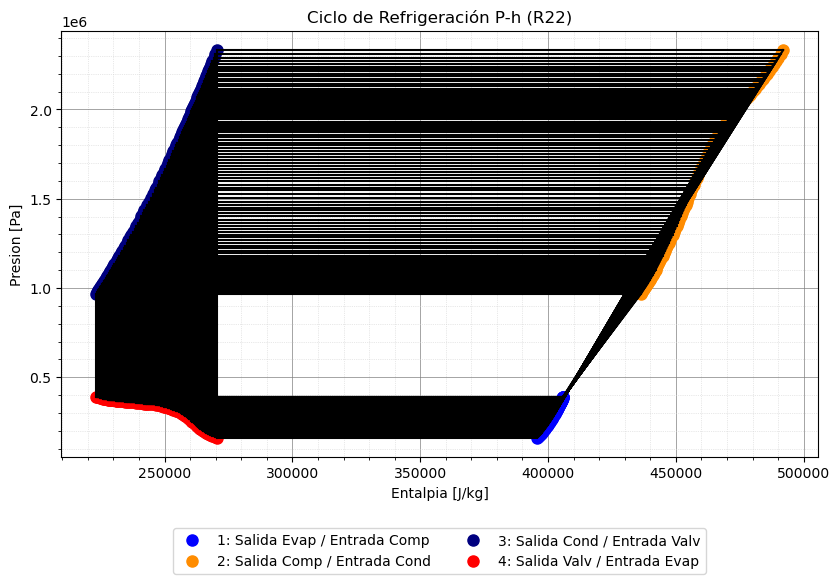

In [44]:
h1 = df_resultados_modelo_inverso['h1']
h2 = df_resultados_modelo_inverso['h2']
h3 = df_resultados_modelo_inverso['h3']
h4 = df_resultados_modelo_inverso['h4']
p_evap = df_resultados_modelo_inverso['P_evap_Pa']
p_cond = df_resultados_modelo_inverso['P_cond_Pa']
plt.figure(figsize=(10, 6))
plt.plot(h1, p_evap, marker='o', markersize=8, color='blue', linestyle='none', label='1: Salida Evap / Entrada Comp')
plt.plot(h2, p_cond, marker='o', markersize=8, color='darkorange', linestyle='none', label='2: Salida Comp / Entrada Cond')
plt.plot(h3, p_cond, marker='o', markersize=8, color='navy', linestyle='none', label='3: Salida Cond / Entrada Valv')
plt.plot(h4, p_evap, marker='o', markersize=8, color='red', linestyle='none', label='4: Salida Valv / Entrada Evap')
plt.plot([h1, h2], [p_evap, p_cond], color='black', linestyle='-')
plt.plot([h2, h3], [p_cond, p_cond], color='black', linestyle='-')
plt.plot([h3, h4], [p_cond, p_evap], color='black', linestyle='-')
plt.plot([h4, h1], [p_evap, p_evap], color='black', linestyle='-')
plt.ylabel("Presion [Pa]")
plt.xlabel("Entalpia [J/kg]")
plt.title("Ciclo de Refrigeración P-h (R22)") # Título ajustado
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=2)
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


Generando datos del diagrama P-h para R22...
Datos del diagrama para R22 generados.


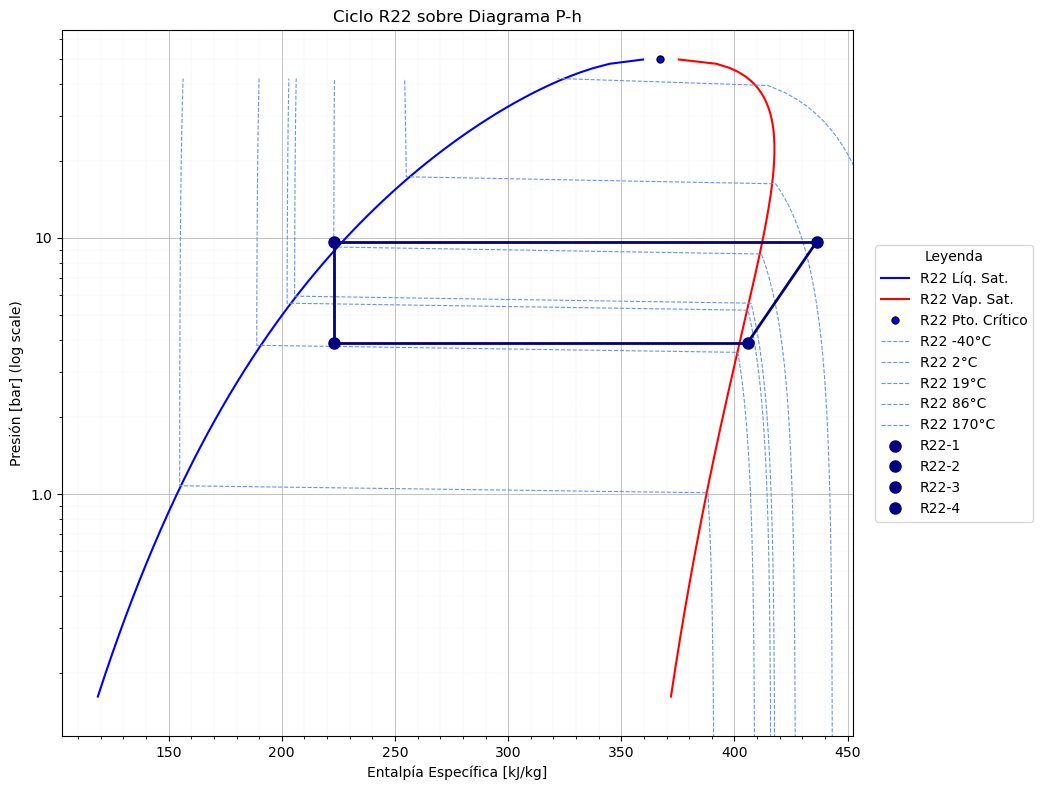

In [45]:

# --- PASO 1: Crear o Cargar DataFrame ---

df_r22 = df_resultados_modelo_inverso


# --- PASO 2: Función para Generar Datos del Diagrama P-h ---

def generar_datos_diagrama_ph(fluido, p_min_cycle_pa, p_max_cycle_pa, df_ciclo_ref):
    """
    Calcula los datos para dibujar las curvas de saturación e isotermas
    de un diagrama P-h para un fluido dado.

    Args:
        fluido (str): Nombre del refrigerante (e.g., 'R22').
        p_min_cycle_pa (float): Presión mínima del ciclo (Pa) para guiar el rango.
        p_max_cycle_pa (float): Presión máxima del ciclo (Pa) para guiar el rango.
        df_ciclo_ref (pd.DataFrame): DataFrame con datos del ciclo (se usa la fila 0).

    Returns:
        dict: Un diccionario conteniendo listas de datos para el diagrama:
              'P_sat': Presiones de saturación (Pa),
              'hL_sat': Entalpías líquido saturado (J/kg),
              'hV_sat': Entalpías vapor saturado (J/kg),
              'P_crit': Presión crítica (Pa),
              'h_crit': Entalpía crítica (J/kg),
              'isotermas_P': Lista de listas de presiones por isoterma (Pa),
              'isotermas_h': Lista de listas de entalpías por isoterma (J/kg),
              'isotermas_T': Lista de temperaturas de las isotermas (K)
              Retorna None si hay error crítico.
    """
    print(f"\nGenerando datos del diagrama P-h para {fluido}...")
    datos = {
        'P_sat': [], 'hL_sat': [], 'hV_sat': [], 'P_crit': None, 'h_crit': None,
        'isotermas_P': [], 'isotermas_h': [], 'isotermas_T': []
    }
    P_validas_sat = [] # Necesario para uso interno

    try:
        P_crit = CP.PropsSI('pcrit', fluido)
        T_crit = CP.PropsSI('Tcrit', fluido)
        datos['P_crit'] = P_crit

        # Definir rango de presiones para el domo de saturación
        P_max_diagrama = P_crit * 0.998 # Más cerca del crítico
        P_min_diagrama = p_min_cycle_pa * 0.1 # Bajar bastante para ver bien el domo
        if P_min_diagrama <= 1000: P_min_diagrama = 1000 # Mínimo absoluto > 0

        presiones_sat = np.logspace(np.log10(P_min_diagrama), np.log10(P_max_diagrama), 150)

        for p in presiones_sat:
            try:
                # Usar filtro de fase para evitar errores cerca del crítico
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore") # Ignorar advertencias comunes de CoolProp
                    hL = CP.PropsSI('H', 'P', p, 'Q', 0, fluido)
                    hV = CP.PropsSI('H', 'P', p, 'Q', 1, fluido)
                datos['hL_sat'].append(hL)
                datos['hV_sat'].append(hV)
                datos['P_sat'].append(p) # Guardar la presión correspondiente
                P_validas_sat.append(p) # Para uso en isotermas
            except ValueError:
                continue # Ignorar puntos donde CoolProp falla

        # Punto crítico
        try:
             datos['h_crit'] = CP.PropsSI('H','P', P_crit,'T', T_crit, fluido)
        except ValueError:
            print(f"Advertencia: No se pudo calcular la entalpía crítica para {fluido}.")
            # Tratar de obtenerlo desde las curvas de saturación si es posible
            if datos['P_sat']:
                 idx_crit_approx = np.argmax(datos['P_sat']) # Punto más alto de presión
                 if idx_crit_approx < len(datos['hL_sat']):
                     datos['h_crit'] = (datos['hL_sat'][idx_crit_approx] + datos['hV_sat'][idx_crit_approx]) / 2

        # Calcular algunas isotermas representativas
        temp_min_iso = 233.15 # -40 C (Ajustar si es necesario)
        temp_max_iso = T_crit * 1.2 # Permitir isotermas ligeramente supercríticas si T_cond > T_crit
        if T_crit < 273.15: temp_min_iso = T_crit * 0.7 # Ajuste para fluidos con Tcrit baja

        # Temperaturas basadas en el ciclo (usando el DataFrame de referencia)
        temps_ciclo = []
        if not df_ciclo_ref.empty:
            try:
                # Usar 'Phase' para manejar regiones monofásicas/bifásicas
                # Usamos la primera fila (índice 0) como referencia
                T_evap = CP.PropsSI('T', 'P', p_min_cycle_pa, 'H', df_ciclo_ref.loc[0,'h1'], fluido) # Estimación T evap
                T_cond = CP.PropsSI('T', 'P', p_max_cycle_pa, 'H', df_ciclo_ref.loc[0,'h3'], fluido) # Estimación T cond
                temps_ciclo = np.linspace(T_evap, T_cond, 3)
            except ValueError:
                print(f"Advertencia: No se pudieron calcular T_evap/T_cond para {fluido} para guiar isotermas.")
            except KeyError as ke:
                 print(f"Advertencia: Clave no encontrada en df_ciclo_ref: {ke}. No se usarán T de ciclo.")


        temps_iso_base = np.linspace(temp_min_iso, temp_max_iso, 6) # ~6 isotermas base
        temperaturas_iso_calc = sorted(list(set(np.concatenate((temps_iso_base, temps_ciclo)))))

        # Rango extendido de presiones para calcular las isotermas completas
        p_min_iso_calc = p_min_cycle_pa * 0.05
        if p_min_iso_calc <= 100: p_min_iso_calc = 100
        p_max_iso_calc = p_max_cycle_pa * 1.8 # Ampliar rango superior


        for T_iso_k in temperaturas_iso_calc:
            if T_iso_k < 150: continue # Evitar temperaturas irrealmente bajas

            h_isoterma = []
            P_isoterma = []
            presiones_isoterma = np.logspace(np.log10(p_min_iso_calc), np.log10(p_max_iso_calc), 100)

            for p_iso in presiones_isoterma:
                try:
                    # Usar CoolProp para obtener la entalpía a T y P dadas
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        h = CP.PropsSI('H', 'T', T_iso_k, 'P', p_iso, fluido)
                    # Validar que el valor de h sea razonable (opcional, pero ayuda)
                    if np.isfinite(h):
                        h_isoterma.append(h)
                        P_isoterma.append(p_iso)
                except ValueError:
                    # Esta combinación T, P puede no ser válida (e.g., T > Tcrit a baja P)
                    continue

            if h_isoterma: # Solo guardar si se generaron puntos válidos
                datos['isotermas_h'].append(h_isoterma)
                datos['isotermas_P'].append(P_isoterma)
                datos['isotermas_T'].append(T_iso_k)

        print(f"Datos del diagrama para {fluido} generados.")
        return datos

    except ImportError:
        print("Error: CoolProp no está instalado o no se pudo importar.")
        print("Intenta: pip install coolprop")
        return None
    except Exception as e:
        print(f"Error inesperado generando datos del diagrama para {fluido}: {e}")
        return None

# --- PASO 3: Generar Datos de Diagrama para R22 ---
# Pasa df_r22 como referencia para las temperaturas del ciclo
datos_diagrama_r22 = generar_datos_diagrama_ph('R22', df_r22['P_evap_Pa'].min(), df_r22['P_cond_Pa'].max(), df_r22)


# --- PASO 4: Crear la Gráfica Estática ---

if datos_diagrama_r22: # Proceder solo si el diagrama de R22 se generó

    fig, ax = plt.subplots(figsize=(12, 8)) # Ajustar tamaño si es necesario

    # --- Dibujar Diagrama R22 ---
    color_r22_liq = 'blue'
    color_r22_vap = 'red'
    color_r22_iso = 'cornflowerblue'
    ls_r22_iso = '--'
    if datos_diagrama_r22['P_sat']:
        ax.plot(np.array(datos_diagrama_r22['hL_sat'])/1000, np.array(datos_diagrama_r22['P_sat'])/1e5,
                color=color_r22_liq, linestyle='-', linewidth=1.5, label='R22 Líq. Sat.')
        ax.plot(np.array(datos_diagrama_r22['hV_sat'])/1000, np.array(datos_diagrama_r22['P_sat'])/1e5,
                color=color_r22_vap, linestyle='-', linewidth=1.5, label='R22 Vap. Sat.')
    if datos_diagrama_r22['P_crit'] and datos_diagrama_r22['h_crit']:
        ax.plot([datos_diagrama_r22['h_crit']/1000],[datos_diagrama_r22['P_crit']/1e5], 'ko',
                markersize=5, mfc=color_r22_liq, label='R22 Pto. Crítico') # Relleno del color del líquido

    # Isotermas R22 (con etiquetas selectivas)
    num_iso_r22 = len(datos_diagrama_r22['isotermas_T'])
    step_r22 = max(1, num_iso_r22 // 4) # Etiquetar ~4 isotermas
    for i in range(num_iso_r22):
        temp_C = datos_diagrama_r22['isotermas_T'][i] - 273.15
        label_iso = f'R22 {temp_C:.0f}°C' if i % step_r22 == 0 else None
        ax.plot(np.array(datos_diagrama_r22['isotermas_h'][i])/1000,
                np.array(datos_diagrama_r22['isotermas_P'][i])/1e5,
                color=color_r22_iso, linestyle=ls_r22_iso, linewidth=0.8, label=label_iso)

    # --- Dibujar Ciclo Estático R22 (usando la primera fila del df) ---
    idx_ciclo = 0 # Usar el primer ciclo (índice 0)
    h1_r22, h2_r22, h3_r22, h4_r22 = df_r22.loc[idx_ciclo, ['h1', 'h2', 'h3', 'h4']]
    p_evap_r22, p_cond_r22 = df_r22.loc[idx_ciclo, ['P_evap_Pa', 'P_cond_Pa']]
    color_ciclo_r22 = 'navy'
    # Puntos del ciclo R22
    ax.plot([h1_r22/1000], [p_evap_r22/1e5], marker='o', ms=8, color=color_ciclo_r22, ls='none', label='R22-1', zorder=10)
    ax.plot([h2_r22/1000], [p_cond_r22/1e5], marker='o', ms=8, color=color_ciclo_r22, ls='none', label='R22-2', zorder=10)
    ax.plot([h3_r22/1000], [p_cond_r22/1e5], marker='o', ms=8, color=color_ciclo_r22, ls='none', label='R22-3', zorder=10)
    ax.plot([h4_r22/1000], [p_evap_r22/1e5], marker='o', ms=8, color=color_ciclo_r22, ls='none', label='R22-4', zorder=10)
    # Líneas del ciclo R22
    ax.plot([h1_r22/1000, h2_r22/1000], [p_evap_r22/1e5, p_cond_r22/1e5], color=color_ciclo_r22, lw=2, zorder=9) # Compresión
    ax.plot([h2_r22/1000, h3_r22/1000], [p_cond_r22/1e5, p_cond_r22/1e5], color=color_ciclo_r22, lw=2, zorder=9) # Condensación
    ax.plot([h3_r22/1000, h4_r22/1000], [p_cond_r22/1e5, p_evap_r22/1e5], color=color_ciclo_r22, lw=2, zorder=9) # Expansión
    ax.plot([h4_r22/1000, h1_r22/1000], [p_evap_r22/1e5, p_evap_r22/1e5], color=color_ciclo_r22, lw=2, zorder=9) # Evaporación


    # --- Configuración Final de Ejes y Leyenda ---

    # Calcular límites globales (solo R22)
    h_min_r22_diag = np.min(datos_diagrama_r22['hL_sat'] + datos_diagrama_r22['hV_sat']) / 1000
    h_max_r22_diag = np.max(datos_diagrama_r22['hL_sat'] + datos_diagrama_r22['hV_sat']) / 1000
    h_min_r22_cycle = min(h1_r22, h2_r22, h3_r22, h4_r22) / 1000
    h_max_r22_cycle = max(h1_r22, h2_r22, h3_r22, h4_r22) / 1000

    h_min_overall = min(h_min_r22_diag, h_min_r22_cycle)
    h_max_overall = max(h_max_r22_diag, h_max_r22_cycle)

    p_min_r22_diag = min(datos_diagrama_r22['P_sat'])
    p_max_r22_diag = max(datos_diagrama_r22['P_sat'])

    p_min_overall_pa = min(p_min_r22_diag, p_evap_r22)
    p_max_overall_pa = max(p_max_r22_diag, p_cond_r22)

    # Añadir márgenes
    h_margin = (h_max_overall - h_min_overall) * 0.05
    ax.set_xlim(h_min_overall - h_margin, h_max_overall + h_margin)

    # Márgenes logarítmicos para presión (en bar)
    p_min_bar_axis = max(p_min_overall_pa / 1e5 * 0.7, 0.1) # Mínimo 0.1 bar
    p_max_bar_axis = p_max_overall_pa / 1e5 * 1.3
    ax.set_ylim(p_min_bar_axis, p_max_bar_axis)

    # Configuración de ejes
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x:.1f}' if x < 10 else f'{x:.0f}')) # Formato Presión en bar
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x:.0f}')) # Formato Entalpía en kJ/kg
    ax.set_ylabel("Presión [bar] (log scale)")
    ax.set_xlabel("Entalpía Específica [kJ/kg]")
    ax.set_title("Ciclo R22 sobre Diagrama P-h") # Título actualizado
    ax.minorticks_on()
    ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='darkgray')
    ax.grid(True, which='minor', linestyle=':', linewidth='0.3', color='lightgray')

    # Leyenda (simplificada, puede ir fuera o dentro)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='medium', title="Leyenda")
    fig.tight_layout(rect=[0, 0, 0.88, 1]) # Ajustar para que quepa la leyenda (puede necesitar ajuste)

    plt.show() # Mostrar la gráfica estática

else:
    print("Error: No se pudieron generar los datos de diagrama para R22. No se puede crear la gráfica.")

Se usará el DataFrame 'df_resultados_modelo_inverso' con 100 ciclos.

Generando datos del diagrama P-h para R22...
Datos del diagrama para R22 generados.
Dibujando 100 ciclos...


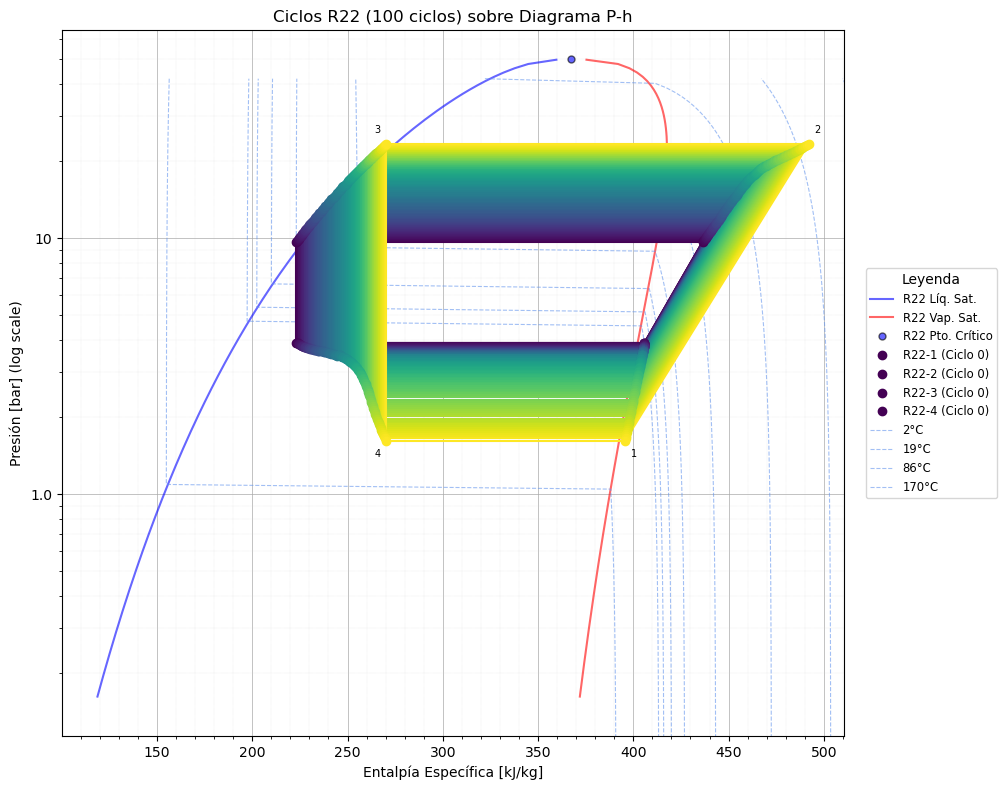

In [62]:

# --- PASO 1: Crear o Cargar DataFrame ---

# Asumiendo que df_resultados_modelo_inverso ya existe y tiene los datos
try:
    df_r22 = df_resultados_modelo_inverso
    print(f"Se usará el DataFrame 'df_resultados_modelo_inverso' con {len(df_r22)} ciclos.")
except NameError:
    print("Error: La variable 'df_resultados_modelo_inverso' no está definida.")


# --- PASO 2: Función para Generar Datos del Diagrama P-h ---
def generar_datos_diagrama_ph(fluido, p_min_cycle_pa, p_max_cycle_pa, df_ciclo_ref):
    print(f"\nGenerando datos del diagrama P-h para {fluido}...")
    datos = {
        'P_sat': [], 'hL_sat': [], 'hV_sat': [], 'P_crit': None, 'h_crit': None,
        'isotermas_P': [], 'isotermas_h': [], 'isotermas_T': []
    }
    P_validas_sat = []

    try:
        P_crit = CP.PropsSI('pcrit', fluido)
        T_crit = CP.PropsSI('Tcrit', fluido)
        datos['P_crit'] = P_crit

        p_min_global = df_ciclo_ref['P_evap_Pa'].min() if not df_ciclo_ref.empty else p_min_cycle_pa
        p_max_global = df_ciclo_ref['P_cond_Pa'].max() if not df_ciclo_ref.empty else p_max_cycle_pa

        P_max_diagrama = P_crit * 0.998
        P_min_diagrama = p_min_global * 0.1
        if P_min_diagrama <= 1000: P_min_diagrama = 1000
        if P_min_diagrama >= P_max_diagrama:
            P_min_diagrama = P_max_diagrama * 0.9
            print(f"Advertencia: P_min_diagrama ajustado a {P_min_diagrama:.2e} Pa")

        presiones_sat = np.logspace(np.log10(P_min_diagrama), np.log10(P_max_diagrama), 150)

        for p in presiones_sat:
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    hL = CP.PropsSI('H', 'P', p, 'Q', 0, fluido)
                    hV = CP.PropsSI('H', 'P', p, 'Q', 1, fluido)
                datos['hL_sat'].append(hL)
                datos['hV_sat'].append(hV)
                datos['P_sat'].append(p)
                P_validas_sat.append(p)
            except ValueError:
                continue

        try:
            datos['h_crit'] = CP.PropsSI('H','P', P_crit,'T', T_crit, fluido)
        except ValueError:
            print(f"Advertencia: No se pudo calcular la entalpía crítica para {fluido}.")
            if datos['P_sat']:
                idx_crit_approx = np.argmax(datos['P_sat'])
                if idx_crit_approx < len(datos['hL_sat']):
                    datos['h_crit'] = (datos['hL_sat'][idx_crit_approx] + datos['hV_sat'][idx_crit_approx]) / 2

        temp_min_iso = 233.15
        temp_max_iso = T_crit * 1.2
        if T_crit < 273.15: temp_min_iso = T_crit * 0.7

        temps_ciclo = []
        if not df_ciclo_ref.empty and all(k in df_ciclo_ref.columns for k in ['h1', 'h3', 'P_evap_Pa', 'P_cond_Pa']):
            try:
                # Usar el primer ciclo como referencia para T típicas
                idx_ref = df_ciclo_ref.index[0]
                T_evap = CP.PropsSI('T', 'P', df_ciclo_ref.loc[idx_ref,'P_evap_Pa'], 'H', df_ciclo_ref.loc[idx_ref,'h1'], fluido)
                T_cond = CP.PropsSI('T', 'P', df_ciclo_ref.loc[idx_ref,'P_cond_Pa'], 'H', df_ciclo_ref.loc[idx_ref,'h3'], fluido)
                temps_ciclo = np.linspace(T_evap, T_cond, 3)
            except ValueError:
                print(f"Advertencia: No se pudieron calcular T_evap/T_cond para {fluido} para guiar isotermas.")
            except KeyError as ke:
                print(f"Advertencia: Clave no encontrada en df_ciclo_ref: {ke}. No se usarán T de ciclo.")

        temps_iso_base = np.linspace(temp_min_iso, temp_max_iso, 6)
        temperaturas_iso_calc = sorted(list(set(np.concatenate((temps_iso_base, temps_ciclo)))))

        p_min_iso_calc = p_min_global * 0.05
        if p_min_iso_calc <= 100: p_min_iso_calc = 100
        p_max_iso_calc = p_max_global * 1.8
        if p_min_iso_calc >= p_max_iso_calc:
            p_min_iso_calc = p_max_iso_calc * 0.9
            print(f"Advertencia: p_min_iso_calc ajustado a {p_min_iso_calc:.2e} Pa")

        for T_iso_k in temperaturas_iso_calc:
            if T_iso_k < 150: continue

            h_isoterma = []
            P_isoterma = []
            num_p_iso = 150 if p_max_iso_calc / max(1,p_min_iso_calc) > 100 else 100 # Evitar división por cero
            presiones_isoterma = np.logspace(np.log10(max(1,p_min_iso_calc)), np.log10(p_max_iso_calc), num_p_iso)


            for p_iso in presiones_isoterma:
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        h = CP.PropsSI('H', 'T', T_iso_k, 'P', p_iso, fluido)
                    if np.isfinite(h) and h > -1e6 and h < 2e6 :
                        h_isoterma.append(h)
                        P_isoterma.append(p_iso)
                except ValueError:
                    continue

            if h_isoterma:
                datos['isotermas_h'].append(h_isoterma)
                datos['isotermas_P'].append(P_isoterma)
                datos['isotermas_T'].append(T_iso_k)

        print(f"Datos del diagrama para {fluido} generados.")
        return datos

    except ImportError:
        print("Error: CoolProp no está instalado o no se pudo importar.")
        print("Intenta: pip install coolprop")
        return None
    except Exception as e:
        print(f"Error inesperado generando datos del diagrama para {fluido}: {e}")
        import traceback
        traceback.print_exc()
        return None

# --- PASO 3: Generar Datos de Diagrama para R22 ---
if not df_r22.empty:
    p_min_ref = df_r22['P_evap_Pa'].min()
    p_max_ref = df_r22['P_cond_Pa'].max()
    datos_diagrama_r22 = generar_datos_diagrama_ph('R22', p_min_ref, p_max_ref, df_r22)
else:
    print("DataFrame df_r22 está vacío. No se pueden generar datos del diagrama.")
    datos_diagrama_r22 = None

# --- PASO 4: Crear la Gráfica Estática con TODOS los ciclos ---

if datos_diagrama_r22 and not df_r22.empty:

    fig, ax = plt.subplots(figsize=(12, 8))

    color_r22_liq = 'blue'
    color_r22_vap = 'red'
    color_r22_iso = 'cornflowerblue'
    ls_r22_iso = '--'
    alpha_diagrama = 0.6
    if datos_diagrama_r22.get('P_sat'):
        ax.plot(np.array(datos_diagrama_r22['hL_sat'])/1000, np.array(datos_diagrama_r22['P_sat'])/1e5,
                color=color_r22_liq, linestyle='-', linewidth=1.5, label='R22 Líq. Sat.', alpha=alpha_diagrama)
        ax.plot(np.array(datos_diagrama_r22['hV_sat'])/1000, np.array(datos_diagrama_r22['P_sat'])/1e5,
                color=color_r22_vap, linestyle='-', linewidth=1.5, label='R22 Vap. Sat.', alpha=alpha_diagrama)
    if datos_diagrama_r22.get('P_crit') and datos_diagrama_r22.get('h_crit'):
        ax.plot([datos_diagrama_r22['h_crit']/1000],[datos_diagrama_r22['P_crit']/1e5], 'ko',
                markersize=5, mfc=color_r22_liq, label='R22 Pto. Crítico', alpha=alpha_diagrama)

    num_iso_r22 = len(datos_diagrama_r22.get('isotermas_T', []))
    step_r22 = max(1, num_iso_r22 // 4)
    isotermas_T = datos_diagrama_r22.get('isotermas_T', [])
    isotermas_h = datos_diagrama_r22.get('isotermas_h', [])
    isotermas_P = datos_diagrama_r22.get('isotermas_P', [])
    for i in range(num_iso_r22):
        temp_C = isotermas_T[i] - 273.15
        label_iso = f'{temp_C:.0f}°C' if i % step_r22 == 0 and i > 0 else None
        ax.plot(np.array(isotermas_h[i])/1000,
                np.array(isotermas_P[i])/1e5,
                color=color_r22_iso, linestyle=ls_r22_iso, linewidth=0.8, label=label_iso, alpha=alpha_diagrama)

    num_ciclos_total = len(df_r22)
    colors = plt.cm.viridis(np.linspace(0, 1, num_ciclos_total))

    print(f"Dibujando {num_ciclos_total} ciclos...")

    text_fontsize = 7
    text_color_points = 'black'
    text_zorder_points = 12

    h_text_offset = 3
    p_text_factor_above = 1.08
    p_text_factor_below = 1 / 1.08

    # Identificar el índice del último ciclo
    idx_ultimo_ciclo = df_r22.index[-1] if num_ciclos_total > 0 else None

    for idx_ciclo, color_ciclo in zip(df_r22.index, colors):
        try:
            h1, h2, h3, h4 = df_r22.loc[idx_ciclo, ['h1', 'h2', 'h3', 'h4']]
            p_evap, p_cond = df_r22.loc[idx_ciclo, ['P_evap_Pa', 'P_cond_Pa']]
        except KeyError as e:
            print(f"Advertencia: Falta la columna {e} en el índice {idx_ciclo}. Saltando este ciclo.")
            continue
        except Exception as e:
            print(f"Error extrayendo datos para el índice {idx_ciclo}: {e}. Saltando este ciclo.")
            continue

        h1_plt, h2_plt, h3_plt, h4_plt = h1/1000, h2/1000, h3/1000, h4/1000
        p_evap_plt, p_cond_plt = p_evap/1e5, p_cond/1e5

        # Modificación para las etiquetas de los puntos (solo para el primer ciclo para la leyenda)
        label_suffix = f" (Ciclo {idx_ciclo})" if num_ciclos_total > 1 else ""
        label_p1 = f'R22-1{label_suffix}' if idx_ciclo == df_r22.index[0] else None # Leyenda solo para el primer ciclo
        label_p2 = f'R22-2{label_suffix}' if idx_ciclo == df_r22.index[0] else None
        label_p3 = f'R22-3{label_suffix}' if idx_ciclo == df_r22.index[0] else None
        label_p4 = f'R22-4{label_suffix}' if idx_ciclo == df_r22.index[0] else None
        label_line = f'Ciclo R22 {idx_ciclo}' if num_ciclos_total <= 5 and idx_ciclo == df_r22.index[0] else None


        ax.plot([h1_plt], [p_evap_plt], marker='o', ms=6, color=color_ciclo, ls='none', label=label_p1, zorder=10)
        ax.plot([h2_plt], [p_cond_plt], marker='o', ms=6, color=color_ciclo, ls='none', label=label_p2, zorder=10)
        ax.plot([h3_plt], [p_cond_plt], marker='o', ms=6, color=color_ciclo, ls='none', label=label_p3, zorder=10)
        ax.plot([h4_plt], [p_evap_plt], marker='o', ms=6, color=color_ciclo, ls='none', label=label_p4, zorder=10)

        # --- MODIFICACIÓN AQUÍ ---
        # Dibujar etiquetas de puntos (1, 2, 3, 4) SOLO para el ÚLTIMO ciclo
        if idx_ciclo == idx_ultimo_ciclo:
            # Punto 1
            ax.text(h1_plt + h_text_offset, p_evap_plt * p_text_factor_below, "1",
                    fontsize=text_fontsize, color=text_color_points, zorder=text_zorder_points,
                    ha='left', va='top')

            # Punto 2
            ax.text(h2_plt + h_text_offset, p_cond_plt * p_text_factor_above, "2",
                    fontsize=text_fontsize, color=text_color_points, zorder=text_zorder_points,
                    ha='left', va='bottom')

            # Punto 3
            ax.text(h3_plt - h_text_offset, p_cond_plt * p_text_factor_above, "3",
                    fontsize=text_fontsize, color=text_color_points, zorder=text_zorder_points,
                    ha='right', va='bottom')

            # Punto 4
            ax.text(h4_plt - h_text_offset, p_evap_plt * p_text_factor_below, "4",
                    fontsize=text_fontsize, color=text_color_points, zorder=text_zorder_points,
                    ha='right', va='top')
        # --- FIN DE LA MODIFICACIÓN ---

        ax.plot([h1_plt, h2_plt], [p_evap_plt, p_cond_plt], color=color_ciclo, lw=1.5, zorder=9, label=label_line if label_line and label_p1 is None else None)
        ax.plot([h2_plt, h3_plt], [p_cond_plt, p_cond_plt], color=color_ciclo, lw=1.5, zorder=9)
        ax.plot([h3_plt, h4_plt], [p_cond_plt, p_evap_plt], color=color_ciclo, lw=1.5, zorder=9)
        ax.plot([h4_plt, h1_plt], [p_evap_plt, p_evap_plt], color=color_ciclo, lw=1.5, zorder=9)

    # ... (resto del código del PASO 4 para configuración de ejes, leyenda, etc.)
    h_cols = ['h1', 'h2', 'h3', 'h4']
    p_cols = ['P_evap_Pa', 'P_cond_Pa']

    if all(col in df_r22.columns for col in h_cols):
        h_min_all_cycles = df_r22[h_cols].min().min() / 1000
        h_max_all_cycles = df_r22[h_cols].max().max() / 1000
    else:
        print("Advertencia: Faltan columnas de entalpía en el DataFrame para calcular límites.")
        h_min_all_cycles, h_max_all_cycles = np.inf, -np.inf

    if all(col in df_r22.columns for col in p_cols):
        p_min_all_cycles_pa = df_r22['P_evap_Pa'].min()
        p_max_all_cycles_pa = df_r22['P_cond_Pa'].max()
    else:
        print("Advertencia: Faltan columnas de presión en el DataFrame para calcular límites.")
        p_min_all_cycles_pa, p_max_all_cycles_pa = np.inf, -np.inf

    h_min_diag_vals = []
    if datos_diagrama_r22.get('hL_sat'): h_min_diag_vals.extend(datos_diagrama_r22['hL_sat'])
    if datos_diagrama_r22.get('hV_sat'): h_min_diag_vals.extend(datos_diagrama_r22['hV_sat'])
    h_min_diag = np.min(h_min_diag_vals) / 1000 if h_min_diag_vals else np.inf

    h_max_diag_vals = []
    if datos_diagrama_r22.get('hL_sat'): h_max_diag_vals.extend(datos_diagrama_r22['hL_sat'])
    if datos_diagrama_r22.get('hV_sat'): h_max_diag_vals.extend(datos_diagrama_r22['hV_sat'])
    h_max_diag = np.max(h_max_diag_vals) / 1000 if h_max_diag_vals else -np.inf

    h_min_overall = min(h_min_diag, h_min_all_cycles)
    h_max_overall = max(h_max_diag, h_max_all_cycles)

    p_min_diag_pa = np.min(datos_diagrama_r22.get('P_sat', [np.inf]))
    p_crit_pa = datos_diagrama_r22.get('P_crit', -np.inf)
    p_max_diag_pa = max(np.max(datos_diagrama_r22.get('P_sat', [-np.inf])), p_crit_pa if p_crit_pa else -np.inf)

    p_min_overall_pa = min(p_min_diag_pa, p_min_all_cycles_pa)
    p_max_overall_pa = max(p_max_diag_pa, p_max_all_cycles_pa)

    if not (np.isfinite(h_min_overall) and np.isfinite(h_max_overall) and h_max_overall > h_min_overall):
        print("Error: Límites de entalpía inválidos. Usando valores por defecto.")
        h_min_overall, h_max_overall = 100, 600
    if not (np.isfinite(p_min_overall_pa) and np.isfinite(p_max_overall_pa) and p_max_overall_pa > p_min_overall_pa):
        print("Error: Límites de presión inválidos. Usando valores por defecto.")
        p_min_overall_pa, p_max_overall_pa = 1e5, 30e5

    h_margin = (h_max_overall - h_min_overall) * 0.05
    if h_margin == 0: h_margin = h_max_overall * 0.1 if h_max_overall > 0 else 10
    ax.set_xlim(h_min_overall - h_margin, h_max_overall + h_margin)

    p_min_bar_axis = max(p_min_overall_pa / 1e5 * 0.7, 0.1)
    p_max_bar_axis = p_max_overall_pa / 1e5 * 1.3
    if p_min_bar_axis <= 0: p_min_bar_axis = 0.1
    if p_max_bar_axis <= p_min_bar_axis: p_max_bar_axis = p_min_bar_axis * 10
    ax.set_ylim(p_min_bar_axis, p_max_bar_axis)

    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x:.1f}' if x < 10 else f'{x:.0f}'))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x:.0f}'))
    ax.set_ylabel("Presión [bar] (log scale)")
    ax.set_xlabel("Entalpía Específica [kJ/kg]")
    ax.set_title(f"Ciclos R22 ({num_ciclos_total} ciclos) sobre Diagrama P-h")
    ax.minorticks_on()
    ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='darkgray')
    ax.grid(True, which='minor', linestyle=':', linewidth='0.3', color='lightgray')

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        iso_handles = [h for h, l in zip(handles, labels) if '°C' in l]
        iso_labels = [l for l in labels if '°C' in l]
        other_handles = [h for h, l in zip(handles, labels) if '°C' not in l]
        other_labels = [l for l in labels if '°C' not in l]
        ordered_handles = other_handles + iso_handles
        ordered_labels = other_labels + iso_labels
        ax.legend(ordered_handles, ordered_labels, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='small', title="Leyenda")
        fig.tight_layout(rect=[0, 0, 0.85, 1]) # Ajusta el rectángulo para dejar espacio a la leyenda externa
    else:
        fig.tight_layout()

    plt.show()

elif df_r22.empty:
    print("El DataFrame 'df_r22' (o 'df_resultados_modelo_inverso') está vacío. No se puede graficar.")
else:
    print("Error: No se pudieron generar los datos del diagrama para R22. No se puede crear la gráfica.")

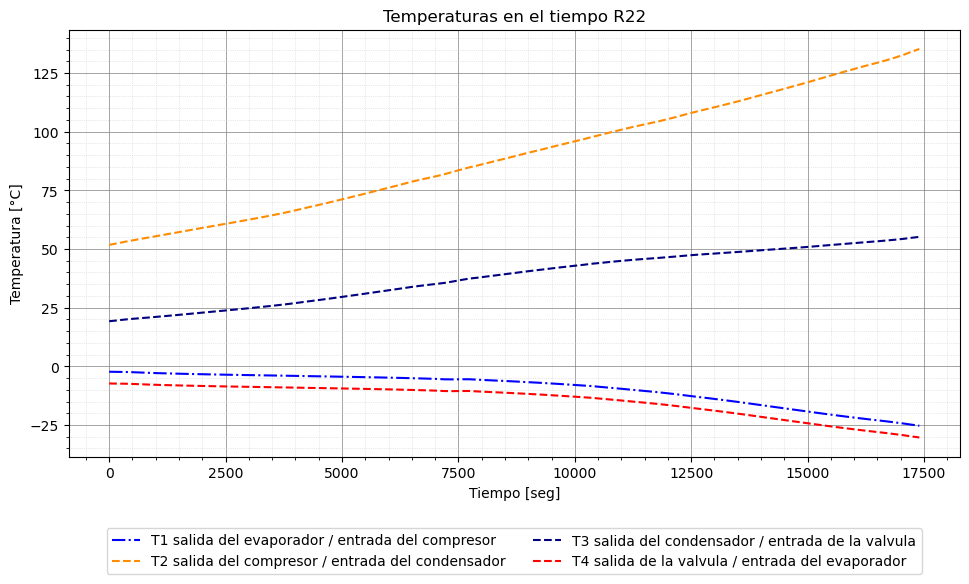

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(tiempo_en_seg,df_resultados_modelo_inverso['T1_K']-273.15,color='blue',linestyle='-.',label='T1 salida del evaporador / entrada del compresor')
plt.plot(tiempo_en_seg,df_resultados_modelo_inverso['T2_K']-273.15,color='darkorange',linestyle='--',label='T2 salida del compresor / entrada del condensador')
plt.plot(tiempo_en_seg,df_resultados_modelo_inverso['T3_K']-273.15,color='navy',linestyle='--',label='T3 salida del condensador / entrada de la valvula')
plt.plot(tiempo_en_seg, df_resultados_modelo_inverso['T4_K']-273.15, color='red', linestyle='--',label='T4 salida de la valvula / entrada del evaporador')
plt.xlabel("Tiempo [seg]")
plt.ylabel("Temperatura [°C]") 
plt.title("Temperaturas en el tiempo R22")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=2)
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray') 
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout()
plt.show()

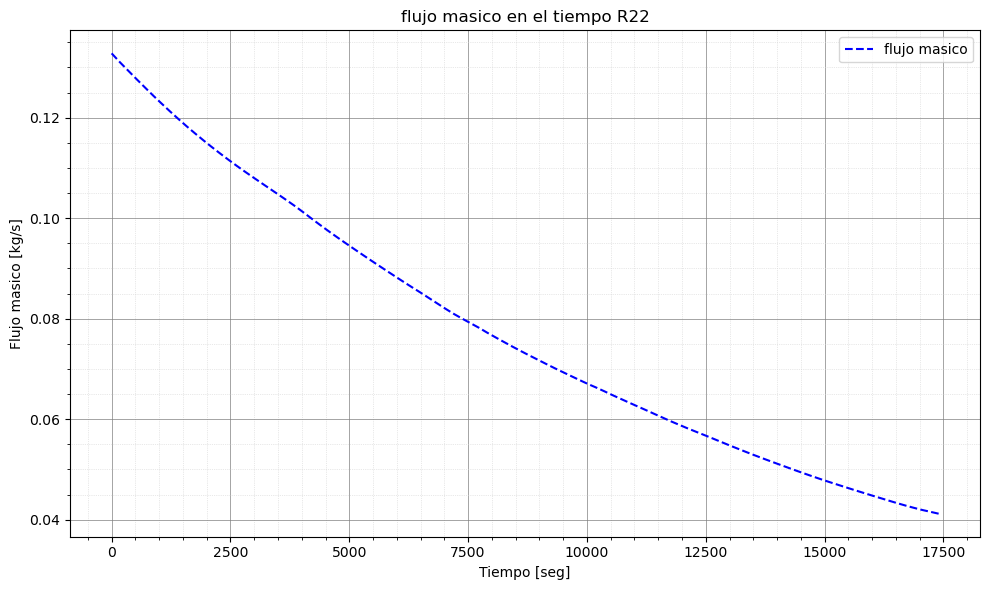

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(tiempo_en_seg,df_resultados_modelo_inverso['m_dot_kgs'],color='blue',linestyle='--',label='flujo masico')
plt.xlabel("Tiempo [seg]")
plt.ylabel("Flujo masico [kg/s]") 
plt.title("flujo masico en el tiempo R22")
plt.legend()
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray') 
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout()
plt.show()

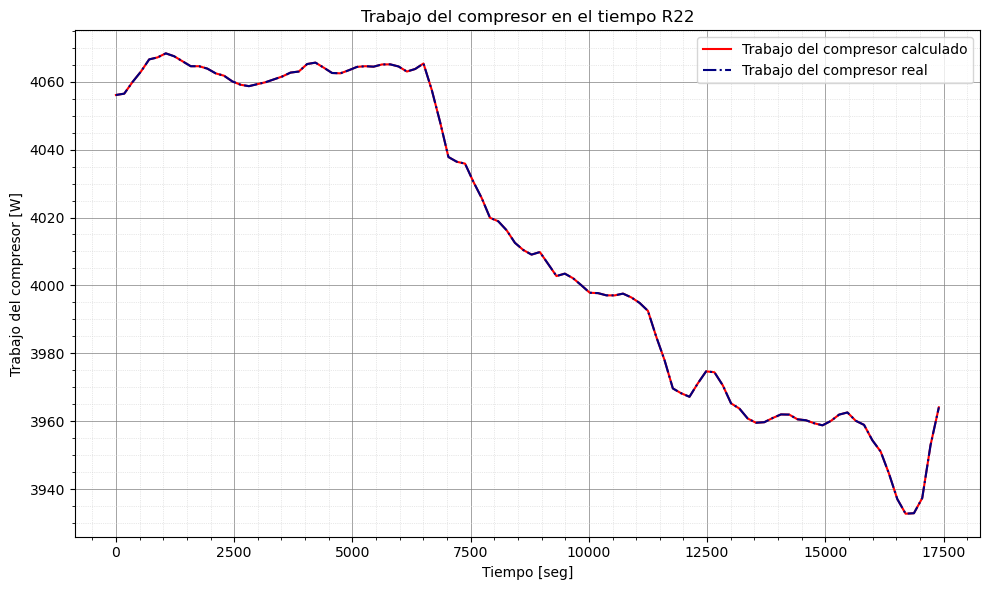

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(tiempo_en_seg,df_resultados_modelo_inverso['W_comp_calc'],color='red',linestyle='-',label='Trabajo del compresor calculado')
plt.plot(tiempo_en_seg,df_resultados_modelo_inverso['W_comp_Target'],color='navy',linestyle='-.',label='Trabajo del compresor real')
plt.xlabel("Tiempo [seg]")
plt.ylabel("Trabajo del compresor [W]") 
plt.title("Trabajo del compresor en el tiempo R22")
plt.legend()
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray') 
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout()
plt.show()

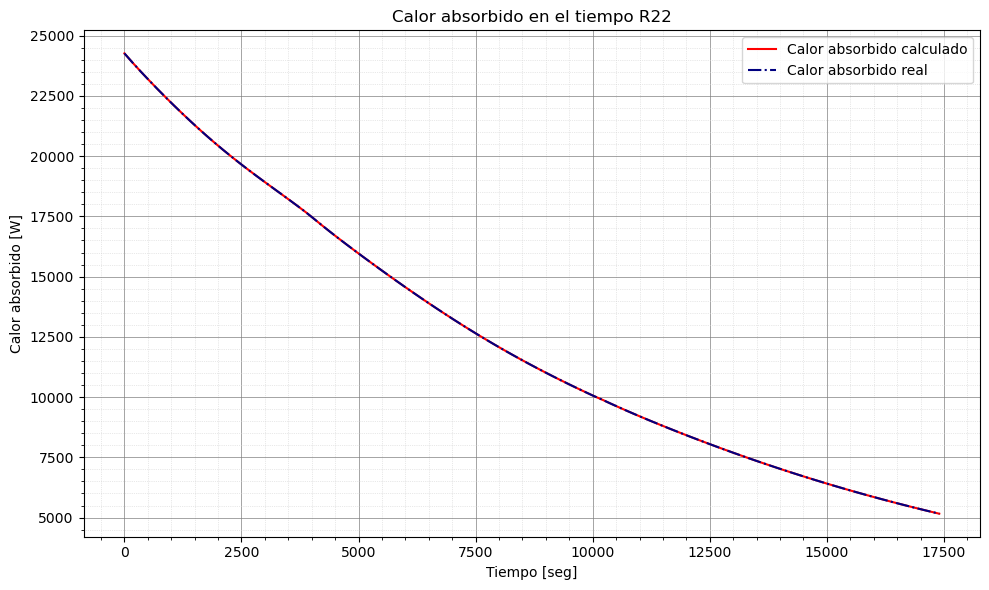

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(tiempo_en_seg,df_resultados_modelo_inverso['Q_evap_calc'],color='red',linestyle='-',label='Calor absorbido calculado')
plt.plot(tiempo_en_seg,df_resultados_modelo_inverso['Q_evap_Target'],color='navy',linestyle='-.',label='Calor absorbido real')
plt.xlabel("Tiempo [seg]")
plt.ylabel("Calor absorbido [W]") 
plt.title("Calor absorbido en el tiempo R22")
plt.legend()
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray') 
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout()
plt.show()

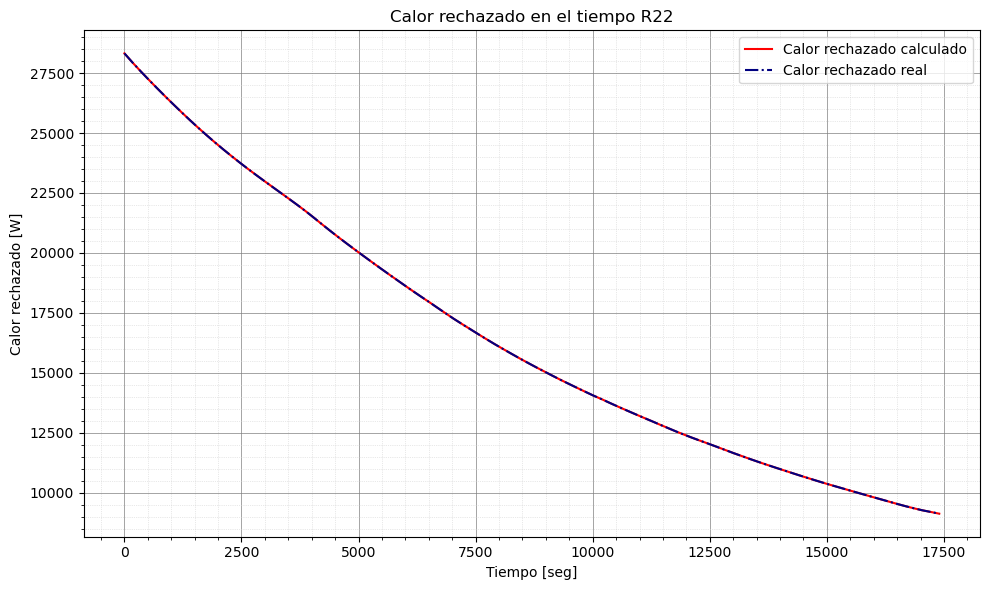

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(tiempo_en_seg,df_resultados_modelo_inverso['Q_cond_calc'],color='red',linestyle='-',label='Calor rechazado calculado')
plt.plot(tiempo_en_seg,df_resultados_modelo_inverso['Q_cond_Target'],color='navy',linestyle='-.',label='Calor rechazado real')
plt.xlabel("Tiempo [seg]")
plt.ylabel("Calor rechazado [W]") 
plt.title("Calor rechazado en el tiempo R22")
plt.legend()
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray') 
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
plt.tight_layout()
plt.show()

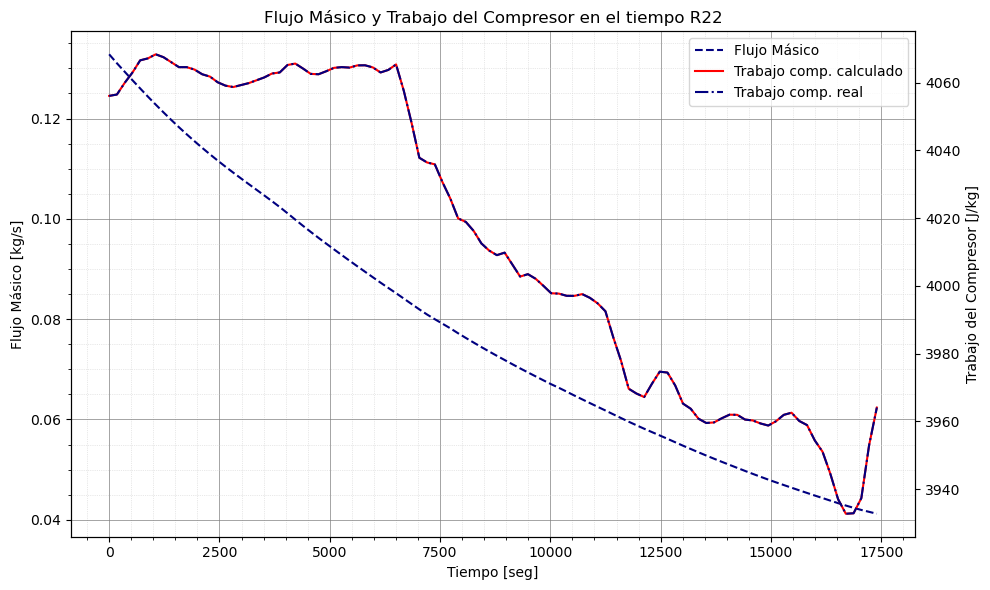

In [52]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Tiempo [seg]")
# CORREGIDO: La etiqueta debe coincidir con los datos (m_dot_kgs)
ax1.set_ylabel("Flujo Másico [kg/s]")
ax1.tick_params(axis='y') # Color de los números del eje Y primario

# 2. Graficar el flujo másico en el EJE PRIMARIO (ax1)
# Guardamos la línea en una variable única
line_flujo, = ax1.plot(tiempo_en_seg, df_resultados_modelo_inverso['m_dot_kgs'], color='navy',linestyle='--', label='Flujo Másico')

# 3. Crear el EJE SECUNDARIO (ax2) que comparte el eje X con ax1
ax2 = ax1.twinx()

# La etiqueta describe ambas líneas en este eje
ax2.set_ylabel("Trabajo del Compresor [J/kg]")
ax2.tick_params(axis='y') # Color de los números del eje Y secundario

# 4. Graficar el trabajo del compresor en el EJE SECUNDARIO (ax2)
# Guardamos CADA línea en variables DIFERENTES


line_w_calc, = ax2.plot(tiempo_en_seg, df_resultados_modelo_inverso['W_comp_calc'], color = 'red',linestyle='-', label='Trabajo comp. calculado')
line_w_target, = ax2.plot(tiempo_en_seg, df_resultados_modelo_inverso['W_comp_Target'],color='navy', linestyle='-.', label='Trabajo comp. real') # Estilo diferente para distinguir

# 5. Configurar Título y Cuadrícula (usando ax1 como referencia principal)
# CORREGIDO: Título para reflejar los datos graficados
ax1.set_title("Flujo Másico y Trabajo del Compresor en el tiempo R22")
ax1.minorticks_on()
# Añadido color a la cuadrícula para mejor visibilidad
ax1.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')

# 6. Crear una LEYENDA COMBINADA
# CORREGIDO: Incluir TODAS las líneas que quieres en la leyenda
lines = [line_flujo, line_w_calc, line_w_target] # Ahora incluimos las 3 líneas
labels = [l.get_label() for l in lines]
# Añadimos la leyenda usando uno de los ejes (ax1)
# Ajustar 'loc' si 'best' no funciona bien (ej. 'upper left', 'center right')
ax1.legend(lines, labels, loc='best')

# 7. Ajustar layout y mostrar
fig.tight_layout() # Ajusta el espaciado para evitar solapamientos
plt.show()

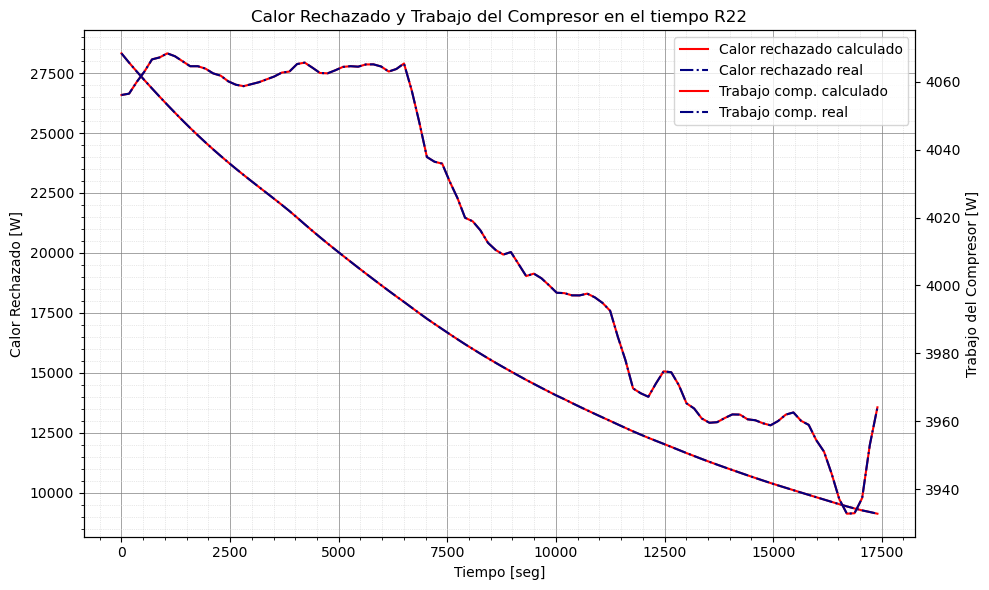

In [53]:
fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.set_xlabel("Tiempo [seg]")
ax1.set_ylabel("Calor Rechazado [W]") # Etiqueta del eje Y primario (Q)
ax1.tick_params(axis='y',) # Color de los números del eje Y primario

# 2. Graficar el Calor Rechazado (Q) en el EJE PRIMARIO (ax1)
# Guardamos las líneas para la leyenda
line_q_calc, = ax1.plot(tiempo_en_seg, df_resultados_modelo_inverso['Q_cond_calc'], color='red',linestyle='-', label='Calor rechazado calculado')
line_q_target, = ax1.plot(tiempo_en_seg, df_resultados_modelo_inverso['Q_cond_Target'], color='navy',linestyle='-.', label='Calor rechazado real') # Estilo diferente

# 3. Crear el EJE SECUNDARIO (ax2) para el Trabajo del Compresor (W)
ax2 = ax1.twinx() # Comparte el mismo eje X


# Asumiendo que el trabajo también está en Watts [W], ajusta si es necesario
ax2.set_ylabel("Trabajo del Compresor [W]") # Etiqueta del eje Y secundario (W)
ax2.tick_params(axis='y') # Color de los números del eje Y secundario

# 4. Graficar el Trabajo del Compresor (W) en el EJE SECUNDARIO (ax2)
# Asumiendo que tienes estas columnas en tu df_resultados_modelo_inverso
# Guardamos las líneas para la leyenda
line_w_calc, = ax2.plot(tiempo_en_seg, df_resultados_modelo_inverso['W_comp_calc'], color='red',linestyle='-', label='Trabajo comp. calculado')
line_w_target, = ax2.plot(tiempo_en_seg, df_resultados_modelo_inverso['W_comp_Target'],color='navy',linestyle='-.', label='Trabajo comp. real') # Estilo diferente

# 5. Configurar Título y Cuadrícula (usando ax1 como referencia principal)
ax1.set_title("Calor Rechazado y Trabajo del Compresor en el tiempo R22") # Título actualizado
ax1.minorticks_on()
ax1.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
# La cuadrícula principal (ax1) se verá detrás de las líneas de ax2

# 6. Crear una LEYENDA COMBINADA para TODAS las líneas
# Juntamos TODAS las líneas (Q y W) y sus etiquetas
lines = [line_q_calc, line_q_target, line_w_calc, line_w_target]
labels = [l.get_label() for l in lines]
# Añadimos la leyenda usando uno de los ejes (ax1)
ax1.legend(lines, labels, loc='best') # 'best' intenta encontrar la mejor ubicación

# 7. Ajustar layout y mostrar
fig.tight_layout() # Ajusta el espaciado para evitar solapamientos
plt.show()

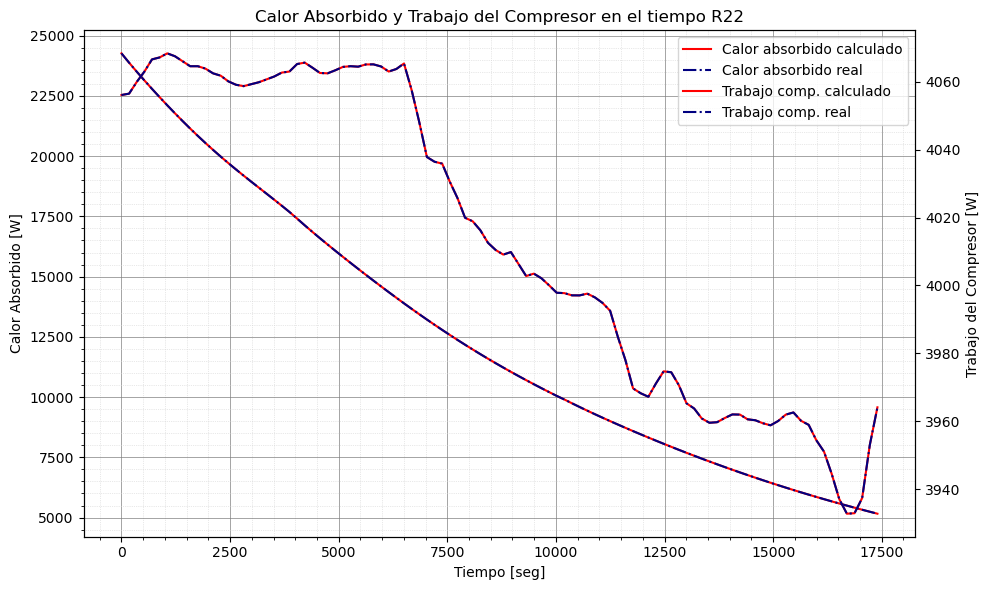

In [54]:
fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.set_xlabel("Tiempo [seg]")
ax1.set_ylabel("Calor Absorbido [W]") # Etiqueta del eje Y primario (Q)
ax1.tick_params(axis='y',) # Color de los números del eje Y primario

# 2. Graficar el Calor Rechazado (Q) en el EJE PRIMARIO (ax1)
# Guardamos las líneas para la leyenda
line_q_calc, = ax1.plot(tiempo_en_seg, df_resultados_modelo_inverso['Q_evap_calc'], color='red',linestyle='-', label='Calor absorbido calculado')
line_q_target, = ax1.plot(tiempo_en_seg, df_resultados_modelo_inverso['Q_evap_Target'], color='navy',linestyle='-.', label='Calor absorbido real') # Estilo diferente

# 3. Crear el EJE SECUNDARIO (ax2) para el Trabajo del Compresor (W)
ax2 = ax1.twinx() # Comparte el mismo eje X


# Asumiendo que el trabajo también está en Watts [W], ajusta si es necesario
ax2.set_ylabel("Trabajo del Compresor [W]") # Etiqueta del eje Y secundario (W)
ax2.tick_params(axis='y') # Color de los números del eje Y secundario

# 4. Graficar el Trabajo del Compresor (W) en el EJE SECUNDARIO (ax2)
# Asumiendo que tienes estas columnas en tu df_resultados_modelo_inverso
# Guardamos las líneas para la leyenda
line_w_calc, = ax2.plot(tiempo_en_seg, df_resultados_modelo_inverso['W_comp_calc'], color='red',linestyle='-', label='Trabajo comp. calculado')
line_w_target, = ax2.plot(tiempo_en_seg, df_resultados_modelo_inverso['W_comp_Target'],color='navy' ,linestyle='-.', label='Trabajo comp. real') # Estilo diferente

# 5. Configurar Título y Cuadrícula (usando ax1 como referencia principal)
ax1.set_title("Calor Absorbido y Trabajo del Compresor en el tiempo R22") # Título actualizado
ax1.minorticks_on()
ax1.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
# La cuadrícula principal (ax1) se verá detrás de las líneas de ax2

# 6. Crear una LEYENDA COMBINADA para TODAS las líneas
# Juntamos TODAS las líneas (Q y W) y sus etiquetas
lines = [line_q_calc, line_q_target, line_w_calc, line_w_target]
labels = [l.get_label() for l in lines]
# Añadimos la leyenda usando uno de los ejes (ax1)
ax1.legend(lines, labels, loc='best') # 'best' intenta encontrar la mejor ubicación

# 7. Ajustar layout y mostrar
fig.tight_layout() # Ajusta el espaciado para evitar solapamientos
plt.show()